In [1]:
%matplotlib notebook

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee
import corner
from scipy import signal
from scipy import stats
from IPython.display import display, Math, Image
import os
from astropy.io import fits
import pandas as pd

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [3]:
dir = os.getcwd()
dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2\\src'

In [4]:
par_dir = os.path.dirname(dir)
par_dir

'C:\\Users\\Marc\\Documents\\repo\\stage_m2'

In [5]:
def log_likelihood(params,time,flux):
        gp.set_parameter_vector(params)
        ll = gp.log_likelihood(flux)
        return ll if np.isfinite(ll) else -np.inf

### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else -np.inf

### Définition du prior (uniforme) ###
def log_prior(params):
    if ((-30 < params[0] < 20) and (-10 < params[1] < 10) and (5 < params[2] < 7) and (-1000 < params[3] < 1000)) :
        return 0
    return -np.inf

### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else -np.inf

    ### MCMC ###
def run_mcmc(time,flux,gp) :
    initial = gp.get_parameter_vector()
    ndim, nwalkers = len(initial), 128
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

    print("Running burn-in...")
    p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
    p0, lp, _ = sampler.run_mcmc(p0, 500,progress=True)

    print("Running production...")
    sampler.reset()
    sampler.run_mcmc(p0, 5000,progress=True)
    print("Finished")
    
    likelihood = gp.log_likelihood(flux)
    af = sampler.acceptance_fraction
    
    print("Mean acceptance fraction:", np.mean(af))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))
    return(sampler,likelihood)

In [6]:
def gp_building(param,time,flux,error) :
    bounds = dict(log_S0= (None,None), log_Q = (-10,10), log_omega0 = (5,7))
    #kernel = terms.SHOTerm(log_S0=7., log_Q=2.5, log_omega0=5.)
    kernel = terms.SHOTerm(log_S0=param[0], log_Q=param[1], log_omega0=param[2],bounds=bounds)

    if len(param)>3 :
        gp = celerite.GP(kernel,mean=param[3],fit_mean=True)
        gp.compute(time,yerr=error)
    else :
        gp = celerite.GP(kernel,fit_mean=True)
        gp.compute(time,yerr=error)
 
    print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
    print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
    
    return gp

In [7]:
### DATA ###
photo_res = pd.read_csv(par_dir + "/data/Posteriors_photometries_norm.csv").ffill().set_index(['Photometry','Sector'])

sectors_names = {
                 "TESS_18_19" : ["All","Sector1","Sector2","Sector3"],
                 "TESS_18_0" : ["All"],
                 "TESS_18_1" : ["All"],
                 "TESS_18_2" : ["All"],
                 "TESS_19" : ["All"],
#                  "TESS_20_0" : ["All"],
#                  "TESS_20_1" : ["All"],
#                  "TESS_21" : ["All"],
                 "TESS_20_0" : ["All","Sector1","Sector2"],
                 "TESS_20_1" : ["All","Sector1","Sector2"],
                 "TESS_21" : ["All","Sector1","Sector2"],
                 "TESS_ALL" : ["All"]
}

rv_time_plot_obs = np.array([544.4,780.71,799.71,829.66,851.32,913.54,1131.79,1170.70,1519.79,1566.70,1597.62,2569.81,2583.88,2685.70,2694.56,2707.08,2985.24,3344.74,3668.00,3712.63,3770.45,3849.51,4007.84,4037.19,4064.77,4094.64,4207.68,4233.60,4525.58,4787.42,4828.73,4907.33,4922.58])

In [8]:
photo_res

Likelihood     Log S0     Log Q    Log w0      Inc - S0  \
Photometry Sector                                                               
TESS_18_0  All      1.019849e+05 -18.371343  0.114515  5.571789  3.637078e-02   
TESS_18_1  All      1.282401e+05 -22.142877  3.109640  5.753980  2.173498e-02   
TESS_18_19 All     -1.797536e+05   0.794191  2.152303  5.764510  1.524011e-02   
           Sector1 -7.557464e+04   1.850714  2.878368  5.757204  2.417274e-02   
           Sector2 -3.655261e+04  -1.308064  1.962317  5.766657  2.747028e-02   
           Sector3          -inf   1.000000  2.500000  5.800000  9.586252e-09   
TESS_18_2  All      1.036524e+05 -21.018158  1.984010  5.746118  2.557890e-02   
TESS_19    All      1.139806e+05 -21.160842  2.071610  5.766508  2.586894e-02   
TESS_20_0  All      1.278628e+05 -22.173189  2.985296  5.743877  2.190292e-02   
           Sector1  6.038764e+04 -22.133714  2.964563  5.745168  3.228885e-02   
           Sector2  6.747721e+04 -22.207452  3.006549  5.742778  2.968010e-02   
TESS_20_1  All      1.264270e+05 -21.997355  2.808794  5.734347  2.306306e-02   
           Sector1  6.458035e+04 -22.364888  3.181210  5.734893  2.915423e-02   
           Sector2  6.201137e+04 -21.563679  2.382038  5.735718  3.484755e-02   
TESS_21    All      1.148365e+05 -20.586130  1.347791  5.765334  2.591646e-02   
           Sector1  6.117571e+04 -22.050071  2.827142  5.737556  3.473868e-02   
           Sector2  5.508625e+04 -19.897529  0.641063  5.800936  3.924218e-02   
TESS_ALL   All      7.126485e+05 -21.536931  2.408500  5.749383  1.026346e-02   

                        Inc + S0       Inc - Q       Inc + Q      Inc - w0  \
Photometry Sector                                                            
TESS_18_0  All      3.808804e-02  2.555585e-02  2.597823e-02  8.706945e-03   
TESS_18_1  All      2.164980e-02  7.522872e-02  8.023418e-02  1.672172e-03   
TESS_18_19 All      1.477054e-02  3.158080e-02  3.250894e-02  1.686901e-03   
           Sector1  2.448385e-02  7.111300e-02  7.515423e-02  2.042177e-03   
           Sector2  2.864101e-02  5.311126e-02  5.528837e-02  3.521550e-03   
           Sector3  9.409456e-09  1.071680e-08  7.983331e-09  1.318782e-08   
TESS_18_2  All      2.573316e-02  5.131981e-02  5.262534e-02  3.252448e-03   
TESS_19    All      2.629465e-02  5.006217e-02  5.359045e-02  3.025405e-03   
TESS_20_0  All      2.152221e-02  7.360135e-02  7.792240e-02  1.842525e-03   
           Sector1  3.244321e-02  1.032279e-01  1.152456e-01  2.740309e-03   
           Sector2  2.993323e-02  9.857547e-02  1.111514e-01  2.518812e-03   
TESS_20_1  All      2.283954e-02  6.697738e-02  7.115105e-02  2.050839e-03   
           Sector1  2.915314e-02  1.112888e-01  1.269617e-01  2.321762e-03   
           Sector2  3.527021e-02  8.016003e-02  8.680767e-02  3.502587e-03   
TESS_21    All      2.614042e-02  3.754078e-02  3.906742e-02  4.159716e-03   
           Sector1  3.447207e-02  9.779545e-02  1.081511e-01  2.841622e-03   
           Sector2  3.975527e-02  3.997399e-02  3.992870e-02  8.322816e-03   
TESS_ALL   All      1.031084e-02  2.410023e-02  2.449232e-02  1.015423e-03   

                        Inc + w0       RMS  
Photometry Sector                           
TESS_18_0  All      8.675925e-03  0.000019  
TESS_18_1  All      1.680591e-03  0.000044  
TESS_18_19 All      1.676897e-03  2.158865  
           Sector1  1.989617e-03  5.697959  
           Sector2  3.518713e-03  0.651420  
           Sector3  8.097019e-09  0.651420  
TESS_18_2  All      3.289525e-03  0.000038  
TESS_19    All      2.992384e-03  0.000041  
TESS_20_0  All      1.827499e-03  0.000043  
           Sector1  2.664619e-03  0.000043  
           Sector2  2.432852e-03  0.000044  
TESS_20_1  All      1.998886e-03  0.000044  
           Sector1  2.346271e-03  0.000042  
           Sector2  3.505076e-03  0.000044  
TESS_21    All      4.195461e-03  0.000034  
           Sector1  2.836233e-03  0.000047  
           Sector2  8.342365e-

In [9]:
# columns = ["Photometry","Sector","RV group","Likelihood","Log S0","Log Q","Log w0","Offset","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0","Inc - Offset","Inc + Offset","RMS"]
# rows = sectors_names.keys()
# res = pd.DataFrame(columns=columns)
# bnds = np.array([542.51,542.61,544.551,544.554,545.519,545.522,546.49,546.576,780.69,780.74,799.67,799.76,829.62,829.71,847.61,847.672,853.58,853.68,878.57,878.65,913.49,913.59,1131.71,1131.76,1131.83,1131.88,1170.67,1170.74,1519.75,1519.84,1565.63,1565.72,1567.67,1567.76,1597.58,1597.67,2569.77,2569.85,2580.79,2580.85,2583.82,2583.89,2584.84,2584.88,2685.67,2685.74,2694.53,2694.6,2706.52,2706.59,2707.58,2707.64,2773.46,2773.53,2980.82,2980.86,2982.83,2982.87,2988.69,2988.75,3040.55,3043.83,3333.85,3333.89,3344.73,3344.77,3492.46,3494.54,3666.80,3666.85,3668.74,3668.81,3711.69,3711.75,3712.68,3712.75,3713.84,3713.9,3768.51,3768.79,3769.71,3769.78,3770.55,3770.61,3771.67,3771.73,3772.59,3772.66,3773.64,3773.71,3774.75,3774.81,3849.46,3849.56,3905.44,3905.46,4007.8,4007.9,4035.67,4035.92,4036.68,4036.92,4038.66,4038.91,4039.66,4039.88,4064.71,4064.82,4093.5,4093.89,4094.57,4094.9,4095.52,4095.9,4206.48,4206.64,4207.5,4207.64,4208.48,4208.63,4226.47,4226.58,4227.48,4227.58,4228.45,4228.58,4229.46,4229.58,4230.46,4230.57,4231.46,4231.57,4238.47,4238.55,4239.5,4239.54,4242.45,4242.54,4243.45,4243.54,4244.45,4244.53,4525.52,4525.67,4786.61,4786.88,4787.62,4787.78,4789.61,4789.64,4827.60,4827.86,4828.58,4828.85,4829.6,4829.85,4905.5,4905.59,4906.5,4906.58,4908.51,4908.58,4909.52,4909.57,4921.49,4921.68,4922.49,4922.62,4923.49,4923.68])
# rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
# rv_time = rv_data[:,0]
# rv_time_plot_ind = np.array([])
# for key in sectors_names.keys() :
#     for name in sectors_names[key] :
#         for j in range(np.int(len(bnds)/2)) :
#             index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
#             rv_time_plot = np.mean(np.sort(np.ndarray.flatten(rv_time[index])))
#             df2 = pd.DataFrame([[key,name,rv_time_plot],[]],columns=['Photometry','Sector','RV group'])
#             res = res.append(df2.loc[0])
#             rv_time_plot_ind = np.append(rv_time_plot_ind,rv_time_plot)
# res.set_index(["Photometry","Sector","RV group"],inplace=True)
# res.sort_index(inplace=True)
# res

columns = ["Photometry","Sector","RV group","Likelihood","Log S0","Log Q","Log w0","Offset","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0","Inc - Offset","Inc + Offset","RMS"]
rows = sectors_names.keys()
res = pd.DataFrame(columns=columns)
# bnds = np.array([542.51,542.61,544.551,544.554,545.519,545.522,546.49,546.576,780.69,780.74,799.67,799.76,829.62,829.71,847.61,847.672,853.58,853.68,878.57,878.65,913.49,913.59,1131.71,1131.76,1131.83,1131.88,1170.67,1170.74,1519.75,1519.84,1565.63,1565.72,1567.67,1567.76,1597.58,1597.67,2569.77,2569.85,2580.79,2580.85,2583.82,2583.89,2584.84,2584.88,2685.67,2685.74,2694.53,2694.6,2706.52,2706.59,2707.58,2707.64,2773.46,2773.53,2980.82,2980.86,2982.83,2982.87,2988.69,2988.75,3040.55,3043.83,3333.85,3333.89,3344.73,3344.77,3492.46,3494.54,3666.80,3666.85,3668.74,3668.81,3711.69,3711.75,3712.68,3712.75,3713.84,3713.9,3768.51,3768.79,3769.71,3769.78,3770.55,3770.61,3771.67,3771.73,3772.59,3772.66,3773.64,3773.71,3774.75,3774.81,3849.46,3849.56,3905.44,3905.46,4007.8,4007.9,4035.67,4035.92,4036.68,4036.92,4038.66,4038.91,4039.66,4039.88,4064.71,4064.82,4093.5,4093.89,4094.57,4094.9,4095.52,4095.9,4206.48,4206.64,4207.5,4207.64,4208.48,4208.63,4226.47,4226.58,4227.48,4227.58,4228.45,4228.58,4229.46,4229.58,4230.46,4230.57,4231.46,4231.57,4238.47,4238.55,4239.5,4239.54,4242.45,4242.54,4243.45,4243.54,4244.45,4244.53,4525.52,4525.67,4786.61,4786.88,4787.62,4787.78,4789.61,4789.64,4827.60,4827.86,4828.58,4828.85,4829.6,4829.85,4905.5,4905.59,4906.5,4906.58,4908.51,4908.58,4909.52,4909.57,4921.49,4921.68,4922.49,4922.62,4923.49,4923.68])
rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_time_plot_ind = np.array([])
for key in sectors_names.keys() :
    for name in sectors_names[key] :
        for j in rv_time_plot_obs :
            df2 = pd.DataFrame([[key,name,j],[]],columns=['Photometry','Sector','RV group'])
            res = res.append(df2.loc[0])
res.set_index(["Photometry","Sector","RV group"],inplace=True)
res.sort_index(inplace=True)
res

Likelihood  Log S0  Log Q  Log w0  Offset  \
Photometry Sector RV group                                              
TESS_18_0  All    544.40           NaN     NaN    NaN     NaN     NaN   
                  780.71           NaN     NaN    NaN     NaN     NaN   
                  799.71           NaN     NaN    NaN     NaN     NaN   
                  829.66           NaN     NaN    NaN     NaN     NaN   
                  851.32           NaN     NaN    NaN     NaN     NaN   
...                                ...     ...    ...     ...     ...   
TESS_ALL   All    4525.58          NaN     NaN    NaN     NaN     NaN   
                  4787.42          NaN     NaN    NaN     NaN     NaN   
                  4828.73          NaN     NaN    NaN     NaN     NaN   
                  4907.33          NaN     NaN    NaN     NaN     NaN   
                  4922.58          NaN     NaN    NaN     NaN     NaN   

                            Inc - S0  Inc + S0  Inc - Q  Inc + Q  Inc - w0  \
Photometry Sector RV group                                                   
TESS_18_0  All    544.40         NaN       NaN      NaN      NaN       NaN   
                  780.71         NaN       NaN      NaN      NaN       NaN   
                  799.71         NaN       NaN      NaN      NaN       NaN   
                  829.66         NaN       NaN      NaN      NaN       NaN   
                  851.32         NaN       NaN      NaN      NaN       NaN   
...                              ...       ...      ...      ...       ...   
TESS_ALL   All    4525.58        NaN       NaN      NaN      NaN       NaN   
                  4787.42        NaN       NaN      NaN      NaN       NaN   
                  4828.73        NaN       NaN      NaN      NaN       NaN   
                  4907.33        NaN       NaN      NaN      NaN       NaN   
                  4922.58        NaN       NaN      NaN      NaN       NaN   

                            Inc + w0  Inc - Offset  Inc + Offset  RMS  
Photometry Sector RV group                                             
TESS_18_0  All    544.40         NaN           NaN           NaN  NaN  
                  780.71         NaN           NaN           NaN  NaN  
                  799.71         NaN           NaN           NaN  NaN  
                  829.66         NaN           NaN           NaN  NaN  
                  851.32         NaN           NaN           NaN  NaN  
...                              ...           ...           ...  ...  
TESS_ALL   All    4525.58        NaN           NaN           NaN  NaN  
                  4787.42        NaN           NaN           NaN  NaN  
                  4828.73        NaN           NaN           NaN  NaN  
                  4907.33        NaN           NaN           NaN  NaN  
                  4922.58        NaN           NaN           NaN  NaN  

[594 rows x 14 columns]

In [12]:
# bnds = np.array([3320,3340,3492,3494,3666,3668,3711,3712,3713,3768,3769,3770,3771,3772,3773,3774,3849,3905,4007,4035,4036,4038,4039,4060,4093,4094,4095,4206,4207,4208,4226,4227,4228,4229,4230,4231,4238,4239,4242,4243,4244,4525,4786,4787,4789,4827,4828,4829,4905,4906,4908,4909,4921,4922,4923,4924])
# bnds=np.array([542.51,542.61,544.551,544.554,545.519,545.522,546.49,546.576,780.69,780.74,799.67,799.76,829.62,829.71,847.61,847.672,853.58,853.68,878.57,878.65,913.49,913.59,1131.71,1131.76,1131.83,1131.88,1170.67,1170.74,1519.75,1519.84,1565.63,1565.72,1567.67,1567.76,1597.58,1597.67,2569.77,2569.85,2580.79,2580.85,2583.82,2583.89,2584.84,2584.88,2685.67,2685.74,2694.53,2694.6,2706.52,2706.59,2707.58,2707.64,2773.46,2773.53,2980.82,2980.86,2982.83,2982.87,2988.69,2988.75,3040.55,3043.83,3333.85,3333.89,3344.73,3344.77,3492.46,3494.54,3666.80,3666.85,3668.74,3668.81,3711.69,3711.75,3712.68,3712.75,3713.84,3713.9,3768.51,3768.79,3769.71,3769.78,3770.55,3770.61,3771.67,3771.73,3772.59,3772.66,3773.64,3773.71,3774.75,3774.81,3849.46,3849.56,3905.44,3905.46,4007.8,4007.9,4035.67,4035.92,4036.68,4036.92,4038.66,4038.91,4039.66,4039.88,4064.71,4064.82,4093.5,4093.89,4094.57,4094.9,4095.52,4095.9,4206.48,4206.64,4207.5,4207.64,4208.48,4208.63,4226.47,4226.58,4227.48,4227.58,4228.45,4228.58,4229.46,4229.58,4230.46,4230.57,4231.46,4231.57,4238.47,4238.55,4239.5,4239.54,4242.45,4242.54,4243.45,4243.54,4244.45,4244.53,4525.52,4525.67,4786.61,4786.88,4787.62,4787.78,4789.61,4789.64,4827.60,4827.86,4828.58,4828.85,4829.6,4829.85,4905.5,4905.59,4906.5,4906.58,4908.51,4908.58,4909.52,4909.57,4921.49,4921.68,4922.49,4922.62,4923.49,4923.68])
bnds = np.array([540,550,780,781,799,800,829,830,847,854,913,914,1131,1132,1170,1171,1519,1520,1565,1568,1597,1598,2569,2570,2580,2585,2685,2686,2694,2695,2706,2708,2980,2989,3344,3345,3666,3669,3711,3714,3768,3775,3849,3850,4007,4008,4035,4040,4064,4065,4093,4096,4206,4209,4226,4245,4525,4526,4786,4790,4827,4830,4905,4910,4921,4924])
#A refaire pour 3712
for photometry in sectors_names.keys() :
    
    for name in sectors_names[photometry] :
        posteriors = photo_res.loc[(photometry,name),"Log S0":"Log w0"]
        
        for j in range(np.int(len(bnds)/2)) :
            print(photometry+"/"+name+"/ %.2f\n"%rv_time_plot_obs[j])
            rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
            rv_time = rv_data[:,0]
            rv_flux = rv_data[:,1]
            rv_error = rv_data[:,2]
            index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
            rv_flux = np.ndarray.flatten(rv_flux[index])
            rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
            rv_error = np.ndarray.flatten(rv_error[index])
            
            
            gp = gp_building(posteriors,rv_time,rv_flux,rv_error)
            sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)
            
            
            flat_samples = sampler.get_chain(discard = 500,thin=15, flat=True)
            labels = ["log(S0)","log(Q)","log(w0)","Offset"]

            rv_posteriors = np.array([])
            rv_posteriors_errors = np.array([])
            corner.corner(flat_samples, labels=labels, truths=[None,posteriors[1],posteriors[2],None])
            plt.title("Posteriors_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
            plt.savefig(par_dir + "/plots/%s/%s/Posteriors_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
            plt.close()  
        #     plt.show()

#             not_flat_samplers = sampler.get_chain(discard = 500, thin=15,flat=False)
#             fig,ax = plt.subplots(2,2)
#             for i in range(not_flat_samplers.shape[2]) :
#                 for cpt in range(2) :
#                     for cpt_1 in range(2) :
#                         if cpt == 0 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
#                         if cpt == 1 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])

#             plt.savefig(par_dir + "/plots/%s/%s/ind/Samplers_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close() 
        #     plt.show()
        
            x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
            pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
            pred_std = np.sqrt(pred_var)

            color = "#ff7f0e"
            plt.figure()
            plt.scatter(rv_time,rv_flux,s=1)
            plt.plot(x, pred_mean, color=color)
            plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
            plt.xlabel("x")
            plt.ylabel("y")
            plt.ylim(np.min(rv_flux),np.max(rv_flux))
            plt.title("Fit_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
            plt.savefig(par_dir + "/plots/%s/%s/Fit_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
            plt.close() 
            
            
            pred_mean, pred_var = gp.predict(rv_flux, rv_time, return_var=True)
            pred_std = np.sqrt(pred_var)
            
            plt.figure()
            plt.scatter(rv_time,rv_flux-pred_mean,s=1)
            plt.xlabel("Time")
            plt.ylabel("Residus")
            plt.title("Residus_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
            plt.savefig(par_dir + "/plots/%s/%s/Residus_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
            plt.close()
            
            RMS = np.sqrt(np.sum((rv_flux - pred_mean)**2)/len(rv_flux))
            res.loc[(photometry,name,rv_time_plot_obs[j]),"RMS"] = RMS

            for i in range(flat_samples.shape[1]):

                mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
                value = np.percentile(flat_samples[:, i], [50])
                q = np.diff(mcmc)
                txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
                display(Math(txt))
                rv_posteriors = np.append(rv_posteriors,value)
                rv_posteriors_errors = np.append(rv_posteriors_errors,q)
                
            res.loc[(photometry,name,rv_time_plot_obs[j]),['Likelihood']] = likelihood    
            res.loc[(photometry,name,rv_time_plot_obs[j]),"Log S0":"Offset"] = rv_posteriors
            res.loc[(photometry,name,rv_time_plot_obs[j]),"Inc - S0" : "Inc + Offset"] = rv_posteriors_errors



  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 544.40

Initial log likelihood: -766.4059600844947
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:51, 44.64it/s]

Running production...


100%|██████████| 5000/5000 [01:52<00:00, 44.60it/s]

Finished
Mean acceptance fraction: 0.5911531250000001
parameter_dict:
OrderedDict([('kernel:log_S0', -10.395787156634754), ('kernel:log_Q', 1.7355032058347424), ('kernel:log_omega0', 5.696256383805378), ('mean:value', -0.02104093294091494)])

Final MCMC log likelihood: 154.91477047623684


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 780.71

Initial log likelihood: -283.35967790568117
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:29, 55.55it/s]

Running production...


100%|██████████| 5000/5000 [01:28<00:00, 56.30it/s]

Finished
Mean acceptance fraction: 0.5818203125
parameter_dict:
OrderedDict([('kernel:log_S0', -8.83291743755851), ('kernel:log_Q', 4.868126189926927), ('kernel:log_omega0', 5.666355435788884), ('mean:value', -0.08529193412575418)])

Final MCMC log likelihood: 29.959750072496334


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 799.71

Initial log likelihood: -662.3657231013096
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:34, 53.09it/s]

Running production...


100%|██████████| 5000/5000 [01:34<00:00, 53.10it/s]

Finished
Mean acceptance fraction: 0.5852125000000001
parameter_dict:
OrderedDict([('kernel:log_S0', -11.708701112002908), ('kernel:log_Q', 3.6952887697192485), ('kernel:log_omega0', 5.617145168322134), ('mean:value', -0.05693988174020996)])

Final MCMC log likelihood: 76.75792158431292


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 829.66

Initial log likelihood: -1010.9142070921431
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:39, 50.42it/s]

Running production...


100%|██████████| 5000/5000 [01:39<00:00, 50.47it/s]

Finished
Mean acceptance fraction: 0.5814781250000001
parameter_dict:
OrderedDict([('kernel:log_S0', -10.718363197863923), ('kernel:log_Q', 3.402571616133704), ('kernel:log_omega0', 5.740854272368656), ('mean:value', -0.20207519147628375)])

Final MCMC log likelihood: 58.13661620999521


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 851.32

Initial log likelihood: -1596.8827064313014
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:45, 47.17it/s]

Running production...


100%|██████████| 5000/5000 [01:47<00:00, 46.42it/s]

Finished
Mean acceptance fraction: 0.5886031249999999
parameter_dict:
OrderedDict([('kernel:log_S0', -8.329397659858667), ('kernel:log_Q', 4.434367847509666), ('kernel:log_omega0', 5.4433586083302155), ('mean:value', -0.051110806813923076)])

Final MCMC log likelihood: 108.74048258656778


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 913.54

Initial log likelihood: -700.0130195172392
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:36, 51.72it/s]

Running production...


100%|██████████| 5000/5000 [01:42<00:00, 48.96it/s]

Finished
Mean acceptance fraction: 0.5857265625
parameter_dict:
OrderedDict([('kernel:log_S0', -12.070460153949771), ('kernel:log_Q', 6.191234161785605), ('kernel:log_omega0', 5.670283500474566), ('mean:value', -0.09631366388060758)])

Final MCMC log likelihood: 72.73310914479123


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 1131.79

Initial log likelihood: -394.6320487653663
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:01, 27.52it/s]

Running production...


100%|██████████| 5000/5000 [01:44<00:00, 47.93it/s]

Finished
Mean acceptance fraction: 0.5764437499999999
parameter_dict:
OrderedDict([('kernel:log_S0', -10.607167360341842), ('kernel:log_Q', 1.9350485400051758), ('kernel:log_omega0', 5.641502809721147), ('mean:value', 0.007074770189103012)])

Final MCMC log likelihood: 57.1742335526543


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 1170.70

Initial log likelihood: -157.5486575025465
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:32, 32.78it/s]

Running production...


100%|██████████| 5000/5000 [01:43<00:00, 48.51it/s]

Finished
Mean acceptance fraction: 0.5839390625
parameter_dict:
OrderedDict([('kernel:log_S0', -12.050344194328943), ('kernel:log_Q', 3.1205991852531385), ('kernel:log_omega0', 5.619609537127353), ('mean:value', -0.009012941097029534)])

Final MCMC log likelihood: 63.43196492685269


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 1519.79

Initial log likelihood: -301.344546217235
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<02:54, 28.57it/s]

Running production...


100%|██████████| 5000/5000 [01:44<00:00, 47.70it/s]

Finished
Mean acceptance fraction: 0.5821828124999999
parameter_dict:
OrderedDict([('kernel:log_S0', -11.519038392048767), ('kernel:log_Q', 5.281034998743552), ('kernel:log_omega0', 5.750024111057234), ('mean:value', 0.03069570464691914)])

Final MCMC log likelihood: 50.70744322576845


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 1566.70

Initial log likelihood: -443.4155241686799
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:55, 43.10it/s]

Running production...


100%|██████████| 5000/5000 [01:56<00:00, 43.00it/s]

Finished
Mean acceptance fraction: 0.5876015625000001
parameter_dict:
OrderedDict([('kernel:log_S0', -10.763026520679988), ('kernel:log_Q', 1.187138474721483), ('kernel:log_omega0', 5.6498863744965275), ('mean:value', 0.11589540710906403)])

Final MCMC log likelihood: 144.92232107263214


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 1597.62

Initial log likelihood: -306.43384595538504
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<02:48, 29.70it/s]

Running production...


100%|██████████| 5000/5000 [01:46<00:00, 46.98it/s]

Finished
Mean acceptance fraction: 0.5843093749999999
parameter_dict:
OrderedDict([('kernel:log_S0', -12.552038679143683), ('kernel:log_Q', 1.8978691172268918), ('kernel:log_omega0', 5.723038259204266), ('mean:value', 0.12291957344970073)])

Final MCMC log likelihood: 57.957313726625145


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 2569.81

Initial log likelihood: -171.21288583373118
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:42<00:00, 48.68it/s]

Finished
Mean acceptance fraction: 0.5783796875
parameter_dict:
OrderedDict([('kernel:log_S0', -7.8161574835423995), ('kernel:log_Q', 0.49201263498518855), ('kernel:log_omega0', 5.484415148867917), ('mean:value', 0.03225721768327333)])

Final MCMC log likelihood: 30.277244597215976


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 2583.88

Initial log likelihood: -234.67893605707565
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/5000 [00:00<04:27, 18.69it/s]

Running production...


100%|██████████| 5000/5000 [01:45<00:00, 47.59it/s]

Finished
Mean acceptance fraction: 0.589646875
parameter_dict:
OrderedDict([('kernel:log_S0', -11.72656307584139), ('kernel:log_Q', 3.8198605928249605), ('kernel:log_omega0', 5.763306417537044), ('mean:value', 0.07636139755397917)])

Final MCMC log likelihood: 48.61754415941908


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 2685.70

Initial log likelihood: -808.4693210933555
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/5000 [00:00<01:39, 50.00it/s]

Running production...


100%|██████████| 5000/5000 [01:42<00:00, 48.60it/s]

Finished
Mean acceptance fraction: 0.5864328125
parameter_dict:
OrderedDict([('kernel:log_S0', -11.37108585523074), ('kernel:log_Q', 3.887183805769756), ('kernel:log_omega0', 5.7364494609698), ('mean:value', 0.02373362127654287)])

Final MCMC log likelihood: 39.01603466623536


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 2694.56

Initial log likelihood: -275.3671604698578
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:18, 36.03it/s]

Running production...


100%|██████████| 5000/5000 [01:43<00:00, 48.14it/s]

Finished
Mean acceptance fraction: 0.580846875
parameter_dict:
OrderedDict([('kernel:log_S0', -10.86445384614883), ('kernel:log_Q', 2.7333844411756014), ('kernel:log_omega0', 5.672083871186143), ('mean:value', 0.13736462593184082)])

Final MCMC log likelihood: 37.68115120720066


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 2707.08

Initial log likelihood: -493.4010376658942
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:32, 32.78it/s]

Running production...


100%|██████████| 5000/5000 [01:48<00:00, 46.09it/s]

Finished
Mean acceptance fraction: 0.5878781249999999
parameter_dict:
OrderedDict([('kernel:log_S0', -10.554000135089963), ('kernel:log_Q', 2.493408147983838), ('kernel:log_omega0', 5.632942589820212), ('mean:value', 0.20139114092705496)])

Final MCMC log likelihood: 88.7197216745685


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 2985.24

Initial log likelihood: -142.82977045206056
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:44, 47.62it/s]

Running production...


100%|██████████| 5000/5000 [01:45<00:00, 47.34it/s]

Finished
Mean acceptance fraction: 0.5909421875
parameter_dict:
OrderedDict([('kernel:log_S0', -12.140943032235128), ('kernel:log_Q', 3.2088321260109947), ('kernel:log_omega0', 5.641466897977089), ('mean:value', 0.013487433485874285)])

Final MCMC log likelihood: 83.88164313043447


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 3344.74

Initial log likelihood: -660.0768225210202
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:09<00:00, 53.71it/s]


Running production...


100%|██████████| 5000/5000 [01:36<00:00, 51.84it/s]

Finished
Mean acceptance fraction: 0.5696046875
parameter_dict:
OrderedDict([('kernel:log_S0', -11.153154876793291), ('kernel:log_Q', 3.0205782259227445), ('kernel:log_omega0', 5.853195953720553), ('mean:value', -0.2068299309891358)])

Final MCMC log likelihood: 46.194913770869185


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 3668.00

Initial log likelihood: -1620.3303508523143
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [01:50<00:00, 45.13it/s]

Finished
Mean acceptance fraction: 0.5883875000000001
parameter_dict:
OrderedDict([('kernel:log_S0', -11.083201059104884), ('kernel:log_Q', 3.7757811298805337), ('kernel:log_omega0', 5.682295380554223), ('mean:value', 0.0893454359784531)])

Final MCMC log likelihood: 124.25710932092787


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 3712.63

Initial log likelihood: -3709.300049557392
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:12<00:00, 40.86it/s]


Running production...


100%|██████████| 5000/5000 [02:01<00:00, 40.99it/s]

Finished
Mean acceptance fraction: 0.5896375
parameter_dict:
OrderedDict([('kernel:log_S0', -10.788872976065438), ('kernel:log_Q', 4.215507053657802), ('kernel:log_omega0', 5.652989226111779), ('mean:value', 0.07655005117048552)])

Final MCMC log likelihood: 137.93890600337613


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 3770.45

Initial log likelihood: -11842.731924484173
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/5000 [00:00<04:47, 17.39it/s]

Running production...


100%|██████████| 5000/5000 [03:30<00:00, 23.79it/s]

Finished
Mean acceptance fraction: 0.5925703124999999
parameter_dict:
OrderedDict([('kernel:log_S0', -10.790285691909752), ('kernel:log_Q', 3.5173856455926242), ('kernel:log_omega0', 5.633925687944739), ('mean:value', 0.08104366817976977)])

Final MCMC log likelihood: 832.9876864269693


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 3849.51

Initial log likelihood: -1299.9457824974136
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/5000 [00:00<02:27, 33.90it/s]

Running production...


100%|██████████| 5000/5000 [01:40<00:00, 49.77it/s]

Finished
Mean acceptance fraction: 0.5828031250000001
parameter_dict:
OrderedDict([('kernel:log_S0', -11.131441997452647), ('kernel:log_Q', 3.2115405518205105), ('kernel:log_omega0', 5.7942086230145025), ('mean:value', 0.15940149105222032)])

Final MCMC log likelihood: 52.73537008270436


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 4007.84

Initial log likelihood: -338.22718183692393
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:44, 47.62it/s]

Running production...


100%|██████████| 5000/5000 [01:44<00:00, 47.91it/s]

Finished
Mean acceptance fraction: 0.5811078125
parameter_dict:
OrderedDict([('kernel:log_S0', -10.73256666150335), ('kernel:log_Q', 1.8797789736123205), ('kernel:log_omega0', 5.798567658062425), ('mean:value', 0.03715059258811272)])

Final MCMC log likelihood: 58.13509174088931


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 4037.19

Initial log likelihood: -9889.82219093185
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<02:53, 28.84it/s]

Running production...


100%|██████████| 5000/5000 [02:57<00:00, 28.19it/s]

Finished
Mean acceptance fraction: 0.59055
parameter_dict:
OrderedDict([('kernel:log_S0', -11.203442298954123), ('kernel:log_Q', 4.696993767679645), ('kernel:log_omega0', 5.714344184883186), ('mean:value', 0.02981352474028765)])

Final MCMC log likelihood: 524.4835965772525


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 4064.77

Initial log likelihood: -946.3729025789563
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/5000 [00:00<01:56, 42.73it/s]

Running production...


100%|██████████| 5000/5000 [01:47<00:00, 46.72it/s]

Finished
Mean acceptance fraction: 0.5853843750000001
parameter_dict:
OrderedDict([('kernel:log_S0', -10.52843906220692), ('kernel:log_Q', 3.79217843447499), ('kernel:log_omega0', 5.665687298316922), ('mean:value', -0.08172695472809625)])

Final MCMC log likelihood: 70.95395259340042


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 4094.64

Initial log likelihood: -14682.483319635128
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:34, 23.25it/s]

Running production...


100%|██████████| 5000/5000 [03:43<00:00, 22.36it/s]

Finished
Mean acceptance fraction: 0.5910359374999999
parameter_dict:
OrderedDict([('kernel:log_S0', -10.731060423593348), ('kernel:log_Q', 3.376773586354228), ('kernel:log_omega0', 5.722429467868266), ('mean:value', -0.03642663162553016)])

Final MCMC log likelihood: 795.3502385089815


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 4207.68

Initial log likelihood: -12944.428688841514
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 500/500 [00:15<00:00, 32.07it/s]


Running production...


100%|██████████| 5000/5000 [02:35<00:00, 32.13it/s]

Finished
Mean acceptance fraction: 0.5910890625
parameter_dict:
OrderedDict([('kernel:log_S0', -10.727752660654419), ('kernel:log_Q', 3.1694179179469346), ('kernel:log_omega0', 5.713627181757745), ('mean:value', -0.037268269939779594)])

Final MCMC log likelihood: 387.6890095111115


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 4233.60

Initial log likelihood: -10030.240363843186
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [03:37<00:00, 22.99it/s]

Finished
Mean acceptance fraction: 0.59385
parameter_dict:
OrderedDict([('kernel:log_S0', -10.740558761741942), ('kernel:log_Q', 2.751768000181138), ('kernel:log_omega0', 5.712656143652761), ('mean:value', -0.07828503569955991)])

Final MCMC log likelihood: 717.061188896422


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 4525.58

Initial log likelihood: -2476.829997543243
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:02<00:00, 40.95it/s]

Finished
Mean acceptance fraction: 0.5845453125
parameter_dict:
OrderedDict([('kernel:log_S0', -10.043357976616477), ('kernel:log_Q', 3.7644112125124245), ('kernel:log_omega0', 5.7553553529369665), ('mean:value', -0.06048748424978442)])

Final MCMC log likelihood: 158.71436411744526


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 4787.42

Initial log likelihood: -2891.2354497892607
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/5000 [00:00<?, ?it/s]

Running production...


100%|██████████| 5000/5000 [02:06<00:00, 39.68it/s]

Finished
Mean acceptance fraction: 0.590828125
parameter_dict:
OrderedDict([('kernel:log_S0', -10.528690737073614), ('kernel:log_Q', 3.2568519901821134), ('kernel:log_omega0', 5.722892658901179), ('mean:value', 0.04202706189835248)])

Final MCMC log likelihood: 120.53509950178204


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 4828.73

Initial log likelihood: -8670.142539053844
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:26, 24.19it/s]

Running production...


100%|██████████| 5000/5000 [03:29<00:00, 23.85it/s]

Finished
Mean acceptance fraction: 0.5920687499999999
parameter_dict:
OrderedDict([('kernel:log_S0', -10.067245297192354), ('kernel:log_Q', 1.484590728157614), ('kernel:log_omega0', 5.687898438015343), ('mean:value', 0.016655665471998236)])

Final MCMC log likelihood: 765.168795533765


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/500 [00:00<?, ?it/s]

TESS_ALL/All/ 4907.33

Initial log likelihood: -4848.304812608333
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/5000 [00:00<04:24, 18.87it/s]

Running production...


100%|██████████| 5000/5000 [02:25<00:00, 34.36it/s]

Finished
Mean acceptance fraction: 0.5912390624999999
parameter_dict:
OrderedDict([('kernel:log_S0', -11.376218450784483), ('kernel:log_Q', 2.8450104240837817), ('kernel:log_omega0', 5.687307087935675), ('mean:value', 0.06627100336231802)])

Final MCMC log likelihood: 313.7462645597028


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_ALL/All/ 4922.58

Initial log likelihood: -6359.653517766259
parameter_dict:
OrderedDict([('kernel:log_S0', -21.53693086194854), ('kernel:log_Q', 2.408499959716872), ('kernel:log_omega0', 5.749382932452834), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/5000 [00:00<03:06, 26.78it/s]

Running production...


100%|██████████| 5000/5000 [03:02<00:00, 27.45it/s]

Finished
Mean acceptance fraction: 0.5903640625
parameter_dict:
OrderedDict([('kernel:log_S0', -10.9431716529526), ('kernel:log_Q', 2.942929496941873), ('kernel:log_omega0', 5.769726408606427), ('mean:value', 0.0710563611823648)])

Final MCMC log likelihood: 552.8685518314575


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [14]:
res.to_csv(par_dir + '/data/Posteriors_RV_TESS_norm.csv')
res

Likelihood     Log S0     Log Q    Log w0  \
Photometry Sector RV group                                              
TESS_18_0  All    544.40    158.074083 -11.265536  2.944867  5.730054   
                  780.71     44.420695 -12.500382  4.579773  5.671684   
                  799.71     69.982564 -11.433797  4.189343  5.572570   
                  829.66     43.563841 -10.797650  3.362585  5.689172   
                  851.32    117.060758 -10.311755  2.561968  5.630306   
...                                ...        ...       ...       ...   
TESS_ALL   All    4525.58   158.714364 -10.476145  3.251678  5.703103   
                  4787.42   120.535100  -9.949568  2.325957  5.712334   
                  4828.73   765.168796 -10.699793  2.420134  5.727765   
                  4907.33   313.746265 -11.057230  3.222082  5.704745   
                  4922.58   552.868552 -11.066228  3.001458  5.767387   

                              Offset  Inc - S0  Inc + S0   Inc - Q   Inc + Q  \
Photometry Sector RV group                                                     
TESS_18_0  All    544.40   -0.079475  0.328057  0.349332  0.533759  0.619445   
                  780.71   -0.062536  1.085565  0.970161  1.404277  1.754957   
                  799.71   -0.068005  0.551117  0.569291  1.064890  1.405162   
                  829.66   -0.200178  0.436822  0.485470  0.830333  1.249748   
                  851.32   -0.133434  0.325369  0.365706  0.624882  0.810073   
...                              ...       ...       ...       ...       ...   
TESS_ALL   All    4525.58  -0.093044  0.291838  0.321849  0.775314  1.230848   
                  4787.42   0.003979  0.218222  0.233759  0.392635  0.487851   
                  4828.73   0.029317  0.133087  0.134705  0.282398  0.352475   
                  4907.33   0.052068  0.243146  0.257828  0.464882  0.564530   
                  4922.58   0.064289  0.167560  0.173788  0.397199  0.506767   

                            Inc - w0  Inc + w0  Inc - Offset  Inc + Offset  \
Photometry Sector RV group                                                   
TESS_18_0  All    544.40    0.026760  0.026638      0.014914      0.014916   
                  780.71    0.032943  0.027744      0.018114      0.017588   
                  799.71    0.034938  0.033205      0.018113      0.018588   
                  829.66    0.025489  0.025218      0.024822      0.024936   
                  851.32    0.041554  0.038462      0.022501      0.023229   
...                              ...       ...           ...           ...   
TESS_ALL   All    4525.58   0.028921  0.027655      0.020939      0.020941   
                  4787.42   0.022650  0.022716      0.017151      0.017248   
                  4828.73   0.015002  0.014451      0.008055      0.008099   
                  4907.33   0.018966  0.018456      0.012436      0.012423   
                  4922.58   0.014269  0.013988      0.008786      0.008803   

                                 RMS  
Photometry Sector RV group            
TESS_18_0  All    544.40    0.060808  
                  780.71    0.037764  
                  799.71    0.054062  
                  829.66    0.072255  
                  851.32    0.053825  
...                              ...  
TESS_ALL   All    4525.58   0.065057  
                  4787.42   0.062237  
                  4828.73   0.048913  
                  4907.33   0.060030  
                  4922.58   0.058208  

[594 rows x 14 columns]

In [66]:
rv_res = pd.read_csv(par_dir + "/data/Posteriors_RV_TESS_norm.csv").ffill().set_index(['Photometry','Sector','RV group'])
columns = ["Photometry","Sector","RV group","Frequency","PSD"]
columns1 = ["Photometry","Sector","RV group","Time","Value"]
rows = sectors_names.keys()
periodo_data = pd.DataFrame(columns=columns)
periodo_data_binned = pd.DataFrame(columns=columns)
periodo_residus = pd.DataFrame(columns=columns)
periodo_residus_binned = pd.DataFrame(columns=columns)
residus = pd.DataFrame(columns=columns1)
residus_binned = pd.DataFrame(columns=columns1)

In [67]:
bnds = np.array([540,550,780,781,799,800,829,830,847,854,913,914,1131,1132,1170,1171,1519,1520,1565,1568,1597,1598,2569,2570,2580,2585,2685,2686,2694,2695,2706,2708,2980,2989,3344,3345,3666,3669,3711,3714,3768,3775,3849,3850,4007,4008,4035,4040,4064,4065,4093,4096,4206,4209,4226,4245,4525,4526,4786,4790,4827,4830,4905,4910,4921,4924])
#A refaire pour 3712
for photometry in sectors_names.keys() :
    
    for name in sectors_names[photometry] :

        for k in range(np.int(len(bnds)/2)) :
            print(photometry+"/"+name+"/ %.2f\n"%rv_time_plot_obs[k])
            rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
            rv_time = rv_data[:,0]
            rv_flux = rv_data[:,1]
            rv_error = rv_data[:,2]
            index = np.argwhere((rv_time>bnds[k*2])&(rv_time<bnds[(k*2)+1]))
            rv_flux = np.ndarray.flatten(rv_flux[index])
            rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
            rv_error = np.ndarray.flatten(rv_error[index])       

            hp = rv_res.loc[(photometry,name,rv_time_plot_obs[k]),"Log S0":"Offset"]
            gp = gp_building(hp,rv_time,rv_flux,rv_error)

            mean, pred_var = gp.predict(rv_flux, rv_time, return_var=True)

            fs = 1/(rv_time[1]-rv_time[0])
            f, P = signal.periodogram(rv_flux,fs)
            f_residus, P_residus = signal.periodogram(rv_flux - mean,fs)

            for j in range(len(f)) :
                df2 = pd.DataFrame([[photometry,name,rv_time_plot_obs[k],f[j],P[j]],[]],columns=['Photometry','Sector','RV group','Frequency',"PSD"])
                periodo_data = periodo_data.append(df2.loc[0])
            for j in range(len(rv_time)) :
                df2 = pd.DataFrame([[photometry,name,rv_time_plot_obs[k],rv_time[j],rv_flux[j] - mean[j]],[]],columns=['Photometry','Sector','RV group','Time',"Value"])
                residus = residus.append(df2.loc[0]) 
            for j in range(len(f_residus)) :
                df2 = pd.DataFrame([[photometry,name,rv_time_plot_obs[k],f_residus[j],P_residus[j]],[]],columns=['Photometry','Sector','RV group','Frequency',"PSD"])
                periodo_residus = periodo_residus.append(df2.loc[0])

            bins_time = np.arange(np.min(rv_time),np.max(rv_time)+0.1,0.1)
            flux_binned,flux_edges,number = stats.binned_statistic(rv_time,rv_flux,statistic='mean',bins=bins_time)
            res_binned,res_edges,number = stats.binned_statistic(rv_time,rv_flux - mean,statistic='mean',bins=bins_time)
            fs_binned = 1/(bins_time[1]-bins_time[0])
            f_flux_binned, P_flux_binned = signal.periodogram(flux_binned,fs_binned)
            f_res_binned, P_res_binned = signal.periodogram(res_binned,fs_binned)

            bin_width_flux = (flux_edges[1] - flux_edges[0])
            bin_centers_flux = flux_edges[1:] - bin_width_flux/2
            bin_width_res = (res_edges[1] - res_edges[0])
            bin_centers_res = res_edges[1:] - bin_width_res/2


            for j in range(len(f_flux_binned)) :
                df2 = pd.DataFrame([[photometry,name,rv_time_plot_obs[k],f_flux_binned[j],P_flux_binned[j]],[]],columns=['Photometry','Sector','RV group','Frequency',"PSD"])
                periodo_data_binned = periodo_data_binned.append(df2.loc[0])       
            for j in range(len(f_res_binned)) :
                df2 = pd.DataFrame([[photometry,name,rv_time_plot_obs[k],f_res_binned[j],P_res_binned[j]],[]],columns=['Photometry','Sector','RV group','Frequency',"PSD"])
                periodo_residus_binned = periodo_residus_binned.append(df2.loc[0])         
            for j in range(len(bin_centers_res)) :
                df2 = pd.DataFrame([[photometry,name,rv_time_plot_obs[k],bin_centers_res[j],res_binned[j]],[]],columns=['Photometry','Sector','RV group','Time',"Value"])
                residus_binned = residus_binned.append(df2.loc[0])
            
periodo_data.set_index(["Photometry","Sector",'RV group','Frequency'],inplace=True)
periodo_data.sort_index(inplace=True) 
periodo_data = periodo_data.dropna() 
periodo_data_binned.set_index(["Photometry","Sector",'RV group','Frequency'],inplace=True)
periodo_data_binned.sort_index(inplace=True)
periodo_data_binned = periodo_data_binned.dropna()
periodo_residus.set_index(["Photometry","Sector",'RV group','Frequency'],inplace=True)
periodo_residus.sort_index(inplace=True)
periodo_residus = periodo_residus.dropna()  
periodo_residus_binned.set_index(["Photometry","Sector",'RV group','Frequency'],inplace=True)
periodo_residus_binned.sort_index(inplace=True)
periodo_residus_binned = periodo_residus_binned.dropna() 
residus.set_index(["Photometry","Sector",'RV group','Time'],inplace=True)
residus.sort_index(inplace=True)
residus = residus.dropna() 
residus_binned.set_index(["Photometry","Sector",'RV group','Time'],inplace=True)
residus_binned.sort_index(inplace=True)
residus_binned = residus_binned.dropna()

TESS_18_19/All/ 544.40

Initial log likelihood: 162.11817132789312
parameter_dict:
OrderedDict([('kernel:log_S0', -11.273065518286293), ('kernel:log_Q', 2.9580277196269766), ('kernel:log_omega0', 5.72992525533708), ('mean:value', -0.0793324424320073)])



C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


TESS_18_19/All/ 780.71

Initial log likelihood: 44.88244906324273
parameter_dict:
OrderedDict([('kernel:log_S0', -12.487306244825763), ('kernel:log_Q', 4.56132439517269), ('kernel:log_omega0', 5.671086677320336), ('mean:value', -0.0620637971850373)])

TESS_18_19/All/ 799.71

Initial log likelihood: 77.87994592290266
parameter_dict:
OrderedDict([('kernel:log_S0', -11.403554621277342), ('kernel:log_Q', 4.133791445294303), ('kernel:log_omega0', 5.574738771355625), ('mean:value', -0.0681538142155122)])

TESS_18_19/All/ 829.66

Initial log likelihood: 60.23303528554676
parameter_dict:
OrderedDict([('kernel:log_S0', -10.784374977594709), ('kernel:log_Q', 3.3585193228293573), ('kernel:log_omega0', 5.689635862039767), ('mean:value', -0.200012746102831)])

TESS_18_19/All/ 851.32

Initial log likelihood: 128.40038110584936
parameter_dict:
OrderedDict([('kernel:log_S0', -10.296822792183796), ('kernel:log_Q', 2.5500218567033466), ('kernel:log_omega0', 5.631601138923536), ('mean:value', -0.13317594

TESS_18_19/Sector1/ 780.71

Initial log likelihood: 44.86018128024183
parameter_dict:
OrderedDict([('kernel:log_S0', -12.435478473413124), ('kernel:log_Q', 4.483865831233256), ('kernel:log_omega0', 5.671043905147426), ('mean:value', -0.0627703184627691)])

TESS_18_19/Sector1/ 799.71

Initial log likelihood: 77.85416167052205
parameter_dict:
OrderedDict([('kernel:log_S0', -11.37854577930034), ('kernel:log_Q', 4.119067820684482), ('kernel:log_omega0', 5.573597955117457), ('mean:value', -0.0680996493555839)])

TESS_18_19/Sector1/ 829.66

Initial log likelihood: 60.219968360725204
parameter_dict:
OrderedDict([('kernel:log_S0', -10.790396316362562), ('kernel:log_Q', 3.397845907563376), ('kernel:log_omega0', 5.689470997867053), ('mean:value', -0.2001657072140108)])

TESS_18_19/Sector1/ 851.32

Initial log likelihood: 128.40573422242892
parameter_dict:
OrderedDict([('kernel:log_S0', -10.297715099346885), ('kernel:log_Q', 2.5468804170759203), ('kernel:log_omega0', 5.6306920492480375), ('mean:v

TESS_18_19/Sector2/ 544.40

Initial log likelihood: 162.1118487231108
parameter_dict:
OrderedDict([('kernel:log_S0', -11.260628419686851), ('kernel:log_Q', 2.934889404273633), ('kernel:log_omega0', 5.730073058938605), ('mean:value', -0.0791497450665775)])

TESS_18_19/Sector2/ 780.71

Initial log likelihood: 44.86171370967449
parameter_dict:
OrderedDict([('kernel:log_S0', -12.458800166948674), ('kernel:log_Q', 4.539689564860777), ('kernel:log_omega0', 5.6714384979261085), ('mean:value', -0.0625708946310101)])

TESS_18_19/Sector2/ 799.71

Initial log likelihood: 77.89253099100006
parameter_dict:
OrderedDict([('kernel:log_S0', -11.415115140623664), ('kernel:log_Q', 4.150279983891074), ('kernel:log_omega0', 5.572869825961653), ('mean:value', -0.067633976357516)])

TESS_18_19/Sector2/ 829.66

Initial log likelihood: 60.244210436138346
parameter_dict:
OrderedDict([('kernel:log_S0', -10.804596120578395), ('kernel:log_Q', 3.3914597596294804), ('kernel:log_omega0', 5.689107152072818), ('mean:va

TESS_18_19/Sector2/ 4922.58

Initial log likelihood: 553.629658236926
parameter_dict:
OrderedDict([('kernel:log_S0', -11.057379015378954), ('kernel:log_Q', 2.9851656623702065), ('kernel:log_omega0', 5.7670661388287705), ('mean:value', 0.0641503482460936)])

TESS_18_19/Sector3/ 544.40

Initial log likelihood: 162.11729492729413
parameter_dict:
OrderedDict([('kernel:log_S0', -11.269252200729616), ('kernel:log_Q', 2.949703171611448), ('kernel:log_omega0', 5.729648977955037), ('mean:value', -0.0796539224576824)])

TESS_18_19/Sector3/ 780.71

Initial log likelihood: 44.86987225680596
parameter_dict:
OrderedDict([('kernel:log_S0', -12.446630319567069), ('kernel:log_Q', 4.488280822586287), ('kernel:log_omega0', 5.671685289613839), ('mean:value', -0.0625553192441249)])

TESS_18_19/Sector3/ 799.71

Initial log likelihood: 77.85998939108234
parameter_dict:
OrderedDict([('kernel:log_S0', -11.374979084002195), ('kernel:log_Q', 4.0845714274907845), ('kernel:log_omega0', 5.5738559976515365), ('mean:

TESS_18_19/Sector3/ 4907.33

Initial log likelihood: 317.52992650420686
parameter_dict:
OrderedDict([('kernel:log_S0', -11.03929904935088), ('kernel:log_Q', 3.197809234108496), ('kernel:log_omega0', 5.705219058699338), ('mean:value', 0.0520390659916005)])

TESS_18_19/Sector3/ 4922.58

Initial log likelihood: 553.6274789864066
parameter_dict:
OrderedDict([('kernel:log_S0', -11.059026280041817), ('kernel:log_Q', 2.9916628722352554), ('kernel:log_omega0', 5.7669127994164455), ('mean:value', 0.0645987784373658)])

TESS_18_0/All/ 544.40

Initial log likelihood: 162.11416933920574
parameter_dict:
OrderedDict([('kernel:log_S0', -11.265536091516932), ('kernel:log_Q', 2.9448673814681072), ('kernel:log_omega0', 5.730053824245497), ('mean:value', -0.0794750365989802)])

TESS_18_0/All/ 780.71

Initial log likelihood: 44.88577284190302
parameter_dict:
OrderedDict([('kernel:log_S0', -12.500381787210232), ('kernel:log_Q', 4.579773148042822), ('kernel:log_omega0', 5.671683978610052), ('mean:value', -0

TESS_18_0/All/ 4907.33

Initial log likelihood: 317.5502889710915
parameter_dict:
OrderedDict([('kernel:log_S0', -11.054322603136049), ('kernel:log_Q', 3.209741938669513), ('kernel:log_omega0', 5.704677012225045), ('mean:value', 0.0523616566034437)])

TESS_18_0/All/ 4922.58

Initial log likelihood: 553.6371037113992
parameter_dict:
OrderedDict([('kernel:log_S0', -11.065504611036545), ('kernel:log_Q', 2.993836236916785), ('kernel:log_omega0', 5.767044206329538), ('mean:value', 0.0640330386717032)])

TESS_18_1/All/ 544.40

Initial log likelihood: 162.11520090346485
parameter_dict:
OrderedDict([('kernel:log_S0', -11.270829427109408), ('kernel:log_Q', 2.95797808058771), ('kernel:log_omega0', 5.72996564623506), ('mean:value', -0.07947558637304)])

TESS_18_1/All/ 780.71

Initial log likelihood: 44.86953621653758
parameter_dict:
OrderedDict([('kernel:log_S0', -12.48187549467036), ('kernel:log_Q', 4.578601359234637), ('kernel:log_omega0', 5.671611050344449), ('mean:value', -0.0621587335681218)

TESS_18_1/All/ 4907.33

Initial log likelihood: 317.54320609641206
parameter_dict:
OrderedDict([('kernel:log_S0', -11.052702954280662), ('kernel:log_Q', 3.21812062412254), ('kernel:log_omega0', 5.704794002728828), ('mean:value', 0.0523658631408731)])

TESS_18_1/All/ 4922.58

Initial log likelihood: 553.6396384423698
parameter_dict:
OrderedDict([('kernel:log_S0', -11.067700933271867), ('kernel:log_Q', 2.994464711174021), ('kernel:log_omega0', 5.767233312878792), ('mean:value', 0.0640470943501384)])

TESS_18_2/All/ 544.40

Initial log likelihood: 162.11625644329317
parameter_dict:
OrderedDict([('kernel:log_S0', -11.26751583692469), ('kernel:log_Q', 2.947228172610968), ('kernel:log_omega0', 5.729705235030327), ('mean:value', -0.0793720197880963)])

TESS_18_2/All/ 780.71

Initial log likelihood: 44.88275585069405
parameter_dict:
OrderedDict([('kernel:log_S0', -12.483328939266578), ('kernel:log_Q', 4.550033616349118), ('kernel:log_omega0', 5.671718143203458), ('mean:value', -0.0620882134606

TESS_18_2/All/ 4907.33

Initial log likelihood: 317.5499441156845
parameter_dict:
OrderedDict([('kernel:log_S0', -11.057778245086585), ('kernel:log_Q', 3.217439303290319), ('kernel:log_omega0', 5.705067512824425), ('mean:value', 0.052412955879894)])

TESS_18_2/All/ 4922.58

Initial log likelihood: 553.6337738493327
parameter_dict:
OrderedDict([('kernel:log_S0', -11.065668882763756), ('kernel:log_Q', 2.9979343505045906), ('kernel:log_omega0', 5.767453417893013), ('mean:value', 0.0642567342864898)])

TESS_19/All/ 544.40

Initial log likelihood: 162.12105895340133
parameter_dict:
OrderedDict([('kernel:log_S0', -11.273765218925677), ('kernel:log_Q', 2.9524187293853963), ('kernel:log_omega0', 5.730231417388822), ('mean:value', -0.0791484337172866)])

TESS_19/All/ 780.71

Initial log likelihood: 44.88669342046441
parameter_dict:
OrderedDict([('kernel:log_S0', -12.49370407363558), ('kernel:log_Q', 4.564492163897786), ('kernel:log_omega0', 5.671400037394327), ('mean:value', -0.0622699772359761

TESS_19/All/ 4907.33

Initial log likelihood: 317.53957621900975
parameter_dict:
OrderedDict([('kernel:log_S0', -11.052144453413074), ('kernel:log_Q', 3.22518692175506), ('kernel:log_omega0', 5.704524108741791), ('mean:value', 0.0521199096765388)])

TESS_19/All/ 4922.58

Initial log likelihood: 553.6274748338207
parameter_dict:
OrderedDict([('kernel:log_S0', -11.066242816907971), ('kernel:log_Q', 3.008943713138996), ('kernel:log_omega0', 5.767030025023525), ('mean:value', 0.0640509836055875)])

TESS_20_0/All/ 544.40

Initial log likelihood: 162.11235055097708
parameter_dict:
OrderedDict([('kernel:log_S0', -11.26799484139958), ('kernel:log_Q', 2.95578015681009), ('kernel:log_omega0', 5.729947959782335), ('mean:value', -0.0791168741077547)])

TESS_20_0/All/ 780.71

Initial log likelihood: 44.88169742533401
parameter_dict:
OrderedDict([('kernel:log_S0', -12.494704805258134), ('kernel:log_Q', 4.576888578064248), ('kernel:log_omega0', 5.671542015312673), ('mean:value', -0.0625273101679377)]

TESS_20_0/All/ 4907.33

Initial log likelihood: 317.554655919208
parameter_dict:
OrderedDict([('kernel:log_S0', -11.057237106141995), ('kernel:log_Q', 3.2100538171099418), ('kernel:log_omega0', 5.704595728477415), ('mean:value', 0.0521282023198505)])

TESS_20_0/All/ 4922.58

Initial log likelihood: 553.6270566065172
parameter_dict:
OrderedDict([('kernel:log_S0', -11.061654258410904), ('kernel:log_Q', 2.998703431211758), ('kernel:log_omega0', 5.767114762415666), ('mean:value', 0.0645029241283408)])

TESS_20_0/Sector1/ 544.40

Initial log likelihood: 162.11578551179426
parameter_dict:
OrderedDict([('kernel:log_S0', -11.26700928843129), ('kernel:log_Q', 2.9458667215186245), ('kernel:log_omega0', 5.729992653246995), ('mean:value', -0.0792873995984065)])

TESS_20_0/Sector1/ 780.71

Initial log likelihood: 44.87849344904802
parameter_dict:
OrderedDict([('kernel:log_S0', -12.48477086031739), ('kernel:log_Q', 4.563646945284862), ('kernel:log_omega0', 5.6715137184209965), ('mean:value', -0.0622

TESS_20_0/Sector1/ 4828.73

Initial log likelihood: 777.5730732852044
parameter_dict:
OrderedDict([('kernel:log_S0', -10.698237680065372), ('kernel:log_Q', 2.417017320079614), ('kernel:log_omega0', 5.727453601239948), ('mean:value', 0.0296429117791854)])

TESS_20_0/Sector1/ 4907.33

Initial log likelihood: 317.55101332424726
parameter_dict:
OrderedDict([('kernel:log_S0', -11.058148260506687), ('kernel:log_Q', 3.2189024524472187), ('kernel:log_omega0', 5.704782184625449), ('mean:value', 0.0521875886170176)])

TESS_20_0/Sector1/ 4922.58

Initial log likelihood: 553.6406729294218
parameter_dict:
OrderedDict([('kernel:log_S0', -11.068051989531025), ('kernel:log_Q', 2.9940977505033937), ('kernel:log_omega0', 5.767165576678158), ('mean:value', 0.0642197804317157)])

TESS_20_0/Sector2/ 544.40

Initial log likelihood: 162.11334271012495
parameter_dict:
OrderedDict([('kernel:log_S0', -11.264074119952326), ('kernel:log_Q', 2.940226529674528), ('kernel:log_omega0', 5.73049722740673), ('mean:value

TESS_20_0/Sector2/ 4787.42

Initial log likelihood: 128.77571394771257
parameter_dict:
OrderedDict([('kernel:log_S0', -9.947087055001369), ('kernel:log_Q', 2.3193593160615977), ('kernel:log_omega0', 5.711969041382458), ('mean:value', 0.0041588021358616)])

TESS_20_0/Sector2/ 4828.73

Initial log likelihood: 777.5679147774347
parameter_dict:
OrderedDict([('kernel:log_S0', -10.699011285959392), ('kernel:log_Q', 2.425908180273526), ('kernel:log_omega0', 5.727334068819957), ('mean:value', 0.0294338901324975)])

TESS_20_0/Sector2/ 4907.33

Initial log likelihood: 317.54399094575183
parameter_dict:
OrderedDict([('kernel:log_S0', -11.053313264558), ('kernel:log_Q', 3.218871325515885), ('kernel:log_omega0', 5.704702473669528), ('mean:value', 0.0524179323388905)])

TESS_20_0/Sector2/ 4922.58

Initial log likelihood: 553.6336404902569
parameter_dict:
OrderedDict([('kernel:log_S0', -11.064916589371355), ('kernel:log_Q', 2.996497332409021), ('kernel:log_omega0', 5.767443131062339), ('mean:value', 

TESS_20_1/All/ 4787.42

Initial log likelihood: 128.77639985867705
parameter_dict:
OrderedDict([('kernel:log_S0', -9.94991732525594), ('kernel:log_Q', 2.323938361358552), ('kernel:log_omega0', 5.712144548144993), ('mean:value', 0.0042064120296909)])

TESS_20_1/All/ 4828.73

Initial log likelihood: 777.5707554034004
parameter_dict:
OrderedDict([('kernel:log_S0', -10.702872530032463), ('kernel:log_Q', 2.4298315369813803), ('kernel:log_omega0', 5.727398223341767), ('mean:value', 0.0294462071990107)])

TESS_20_1/All/ 4907.33

Initial log likelihood: 317.54169666753114
parameter_dict:
OrderedDict([('kernel:log_S0', -11.055019331508625), ('kernel:log_Q', 3.2267201719729237), ('kernel:log_omega0', 5.7049002155481485), ('mean:value', 0.0522907783104336)])

TESS_20_1/All/ 4922.58

Initial log likelihood: 553.6325989036872
parameter_dict:
OrderedDict([('kernel:log_S0', -11.066281829749524), ('kernel:log_Q', 3.0014560897684763), ('kernel:log_omega0', 5.767329041073305), ('mean:value', 0.064149930

TESS_20_1/Sector1/ 4787.42

Initial log likelihood: 128.76631433702312
parameter_dict:
OrderedDict([('kernel:log_S0', -9.944671823853843), ('kernel:log_Q', 2.326942345307056), ('kernel:log_omega0', 5.711871306157122), ('mean:value', 0.0046701595512293)])

TESS_20_1/Sector1/ 4828.73

Initial log likelihood: 777.5719601962076
parameter_dict:
OrderedDict([('kernel:log_S0', -10.701865848280889), ('kernel:log_Q', 2.4266925365123138), ('kernel:log_omega0', 5.727344995379825), ('mean:value', 0.0293604918015407)])

TESS_20_1/Sector1/ 4907.33

Initial log likelihood: 317.5480819500277
parameter_dict:
OrderedDict([('kernel:log_S0', -11.059181136390084), ('kernel:log_Q', 3.2265834993318583), ('kernel:log_omega0', 5.70486894359542), ('mean:value', 0.0522764058879437)])

TESS_20_1/Sector1/ 4922.58

Initial log likelihood: 553.6375107333807
parameter_dict:
OrderedDict([('kernel:log_S0', -11.069105457081516), ('kernel:log_Q', 3.0010253305474333), ('kernel:log_omega0', 5.767072542648926), ('mean:value

TESS_20_1/Sector2/ 4525.58

Initial log likelihood: 163.86017180465643
parameter_dict:
OrderedDict([('kernel:log_S0', -10.479108366792357), ('kernel:log_Q', 3.2421966448421258), ('kernel:log_omega0', 5.703310342541059), ('mean:value', -0.0925818993816028)])

TESS_20_1/Sector2/ 4787.42

Initial log likelihood: 128.76465807091728
parameter_dict:
OrderedDict([('kernel:log_S0', -9.944435008896674), ('kernel:log_Q', 2.326808525379753), ('kernel:log_omega0', 5.712686524334428), ('mean:value', 0.004117820652606)])

TESS_20_1/Sector2/ 4828.73

Initial log likelihood: 777.5728419176792
parameter_dict:
OrderedDict([('kernel:log_S0', -10.703692282400208), ('kernel:log_Q', 2.4288981299563184), ('kernel:log_omega0', 5.727357103979131), ('mean:value', 0.0294047921051674)])

TESS_20_1/Sector2/ 4907.33

Initial log likelihood: 317.55370475612017
parameter_dict:
OrderedDict([('kernel:log_S0', -11.061711043312693), ('kernel:log_Q', 3.2253751920251323), ('kernel:log_omega0', 5.704413292539631), ('mean:va

TESS_21/All/ 4525.58

Initial log likelihood: 163.85627819903033
parameter_dict:
OrderedDict([('kernel:log_S0', -10.474868255865186), ('kernel:log_Q', 3.2387656432570475), ('kernel:log_omega0', 5.702864675458269), ('mean:value', -0.0927750751739256)])

TESS_21/All/ 4787.42

Initial log likelihood: 128.77045673971907
parameter_dict:
OrderedDict([('kernel:log_S0', -9.94372210746448), ('kernel:log_Q', 2.319694197127068), ('kernel:log_omega0', 5.711941556478341), ('mean:value', 0.0041080286680877)])

TESS_21/All/ 4828.73

Initial log likelihood: 777.5758472819418
parameter_dict:
OrderedDict([('kernel:log_S0', -10.702249373311147), ('kernel:log_Q', 2.42229575149388), ('kernel:log_omega0', 5.727460197566913), ('mean:value', 0.0292863733783514)])

TESS_21/All/ 4907.33

Initial log likelihood: 317.5488129531035
parameter_dict:
OrderedDict([('kernel:log_S0', -11.055534280694497), ('kernel:log_Q', 3.216912158524498), ('kernel:log_omega0', 5.704579334870435), ('mean:value', 0.0519475311333811)])


TESS_21/Sector1/ 4525.58

Initial log likelihood: 163.85418212964458
parameter_dict:
OrderedDict([('kernel:log_S0', -10.481029573986568), ('kernel:log_Q', 3.259685306721259), ('kernel:log_omega0', 5.703018288964719), ('mean:value', -0.0929103554974926)])

TESS_21/Sector1/ 4787.42

Initial log likelihood: 128.7738451322502
parameter_dict:
OrderedDict([('kernel:log_S0', -9.94988345771912), ('kernel:log_Q', 2.327986188618105), ('kernel:log_omega0', 5.71190257179223), ('mean:value', 0.0041277552003778)])

TESS_21/Sector1/ 4828.73

Initial log likelihood: 777.5736688263178
parameter_dict:
OrderedDict([('kernel:log_S0', -10.703409829542307), ('kernel:log_Q', 2.426821853948294), ('kernel:log_omega0', 5.727527314824446), ('mean:value', 0.0295642876974352)])

TESS_21/Sector1/ 4907.33

Initial log likelihood: 317.55031382945776
parameter_dict:
OrderedDict([('kernel:log_S0', -11.059226086562866), ('kernel:log_Q', 3.2242981739168872), ('kernel:log_omega0', 5.704601756537472), ('mean:value', 0.0522

TESS_21/Sector2/ 4525.58

Initial log likelihood: 163.83516809234874
parameter_dict:
OrderedDict([('kernel:log_S0', -10.46891604442756), ('kernel:log_Q', 3.259852746295297), ('kernel:log_omega0', 5.702849343601493), ('mean:value', -0.0930773402763944)])

TESS_21/Sector2/ 4787.42

Initial log likelihood: 128.77068704563322
parameter_dict:
OrderedDict([('kernel:log_S0', -9.944705166016778), ('kernel:log_Q', 2.32158083141228), ('kernel:log_omega0', 5.711912583913849), ('mean:value', 0.0041456324819941)])

TESS_21/Sector2/ 4828.73

Initial log likelihood: 777.5719068746828
parameter_dict:
OrderedDict([('kernel:log_S0', -10.70073099824183), ('kernel:log_Q', 2.4245044191532834), ('kernel:log_omega0', 5.72737012677179), ('mean:value', 0.029462537330694)])

TESS_21/Sector2/ 4907.33

Initial log likelihood: 317.54648412055394
parameter_dict:
OrderedDict([('kernel:log_S0', -11.052323217435774), ('kernel:log_Q', 3.214507975069972), ('kernel:log_omega0', 5.704176173462116), ('mean:value', 0.052054

TESS_ALL/All/ 4525.58

Initial log likelihood: 163.85087767730147
parameter_dict:
OrderedDict([('kernel:log_S0', -10.476145016188426), ('kernel:log_Q', 3.251678378162656), ('kernel:log_omega0', 5.70310327480494), ('mean:value', -0.0930439658120504)])

TESS_ALL/All/ 4787.42

Initial log likelihood: 128.77411464690158
parameter_dict:
OrderedDict([('kernel:log_S0', -9.949568218736264), ('kernel:log_Q', 2.325956801446799), ('kernel:log_omega0', 5.712333834169421), ('mean:value', 0.0039794652465269)])

TESS_ALL/All/ 4828.73

Initial log likelihood: 777.5727704358328
parameter_dict:
OrderedDict([('kernel:log_S0', -10.699793280135609), ('kernel:log_Q', 2.4201344452515787), ('kernel:log_omega0', 5.727765105308787), ('mean:value', 0.0293168081916642)])

TESS_ALL/All/ 4907.33

Initial log likelihood: 317.54815215675364
parameter_dict:
OrderedDict([('kernel:log_S0', -11.057230009355656), ('kernel:log_Q', 3.2220818097263577), ('kernel:log_omega0', 5.7047448798354665), ('mean:value', 0.052067925844

In [62]:
periodo_data_binned

PSD
Photometry Sector RV group Frequency               
TESS_18_0  All    780.71   0.000000    7.642579e-37
                           20.571429   3.424493e-04
                           41.142857   2.514121e-03
                           61.714286   2.906193e-04
                           82.285714   7.337660e-05
...                                             ...
TESS_ALL   All    4525.58  112.390244  6.858052e-05
                           119.414634  5.114623e-05
                           126.439024  1.534270e-04
                           133.463415  3.811146e-05
                           140.487805  1.928871e-05

[2574 rows x 1 columns]

In [68]:
periodo_data.to_csv(par_dir + '/data/periodo_norm_rv_data.csv')
periodo_data_binned.to_csv(par_dir + '/data/periodo_norm_rv_data_binned_0.1j.csv')
periodo_residus.to_csv(par_dir + '/data/periodo_norm_rv_residus.csv')
periodo_residus_binned.to_csv(par_dir + '/data/periodo_norm_rv_residus_binned_0.1j.csv')
residus.to_csv(par_dir + '/data/residus_norm_rv.csv')
residus_binned.to_csv(par_dir + '/data/residus_norm_rv_binned_0.1j.csv')

<IPython.core.display.Javascript object>


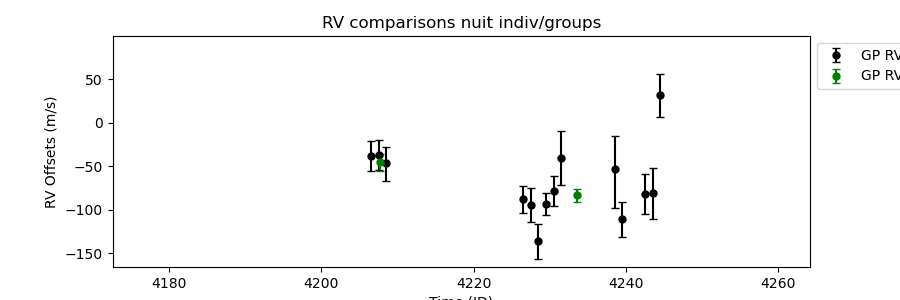

In [80]:
rv_data_20 = pd.read_csv(par_dir + "/data/Posteriors_RV_TESS_20_0_All_ind.csv").ffill().set_index(['Photometry','Sector','RV group'])
rv_data = pd.read_csv(par_dir + "/data/Posteriors_RV.csv").ffill().set_index(['Photometry','Sector','RV group'])
plt.figure(figsize=(9,3))
rv_times_20 = rv_data_20.loc[("TESS_20_0","All")].index.values
rv_times = rv_data.loc[("TESS_20_0","All")].index.values
rv_GP_20 = rv_data_20.loc[("TESS_20_0","All"),("Offset","Inc - Offset","Inc + Offset")].values
rv_GP = rv_data.loc[("TESS_20_0","All"),("Offset","Inc - Offset","Inc + Offset")].values
plt.errorbar(rv_times_20, rv_GP_20[:,0] - np.nanmean(rv_GP_20[:,0]), yerr = rv_GP_20[:,1:3].T, fmt = 'ok', markersize = 5, capsize = 3, label = "GP RV indiv")
plt.errorbar(rv_times, rv_GP[:,0] - np.mean(rv_GP[:,0]), yerr = rv_GP[:,1:3].T, fmt = 'og', markersize = 5, capsize = 3, label = "GP RV groups")
plt.legend(bbox_to_anchor=(1.,1.),loc='upper left')
plt.xlabel("Time (JD)")
plt.ylabel("RV Offsets (m/s)")
plt.title("RV comparisons nuit indiv/groups")
plt.show()


<IPython.core.display.Javascript object>


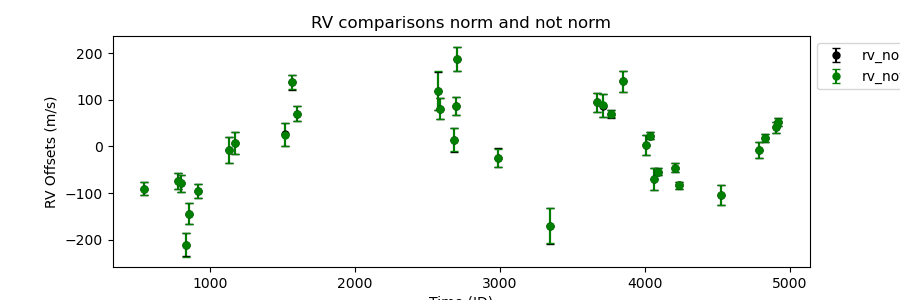

In [14]:
rv_data_norm = pd.read_csv(par_dir + "/data/Posteriors_RV_TESS_norm.csv").ffill().set_index(['Photometry','Sector','RV group'])
rv_data_not_norm = pd.read_csv(par_dir + "/data/Posteriors_RV.csv").ffill().set_index(['Photometry','Sector','RV group'])

plt.figure(figsize=(9,3))
rv_times_norm = rv_data_norm.loc[("TESS_ALL","All")].index.values
rv_times_not_norm = rv_data_not_norm.loc[("TESS_20_0","All")].index.values
rv_GP_norm = rv_data_norm.loc[("TESS_ALL","All"),("Offset","Inc - Offset","Inc + Offset")].values
rv_GP_not_norm = rv_data_not_norm.loc[("TESS_20_0","All"),("Offset","Inc - Offset","Inc + Offset")].values
plt.errorbar(rv_times_norm, (rv_GP_norm[:,0] - np.nanmean(rv_GP_norm[:,0]))*1000, yerr = 1000* rv_GP_norm[:,1:3].T, fmt = 'ok', markersize = 5, capsize = 3, label = "rv_norm_photo")
plt.errorbar(rv_times_not_norm, rv_GP_not_norm[:,0] - np.mean(rv_GP_not_norm[:,0]), yerr = rv_GP_not_norm[:,1:3].T, fmt = 'og', markersize = 5, capsize = 3, label = "rv_not_norm_photo")
plt.legend(bbox_to_anchor=(1.,1.),loc='upper left')
plt.xlabel("Time (JD)")
plt.ylabel("RV Offsets (m/s)")
plt.title("RV comparisons norm and not norm")
plt.show()

In [7]:
### DATA ###
photo_res = pd.read_csv(par_dir + "/data/Posteriors_photometries.csv").ffill().set_index(['Photometry','Sector'])

sectors_names = {"TESS_18_19" : ["All","Sector1","Sector2","Sector3"],
                "TESS_20_0" : ["All","Sector1","Sector2"],
                "TESS_20_1" : ["All","Sector1","Sector2"],
                "TESS_21" : ["All","Sector1","Sector2"]}

rv_time_plot_obs = np.array(["2685.70","2694.56","2707.08","2680-2710","4233.60","4226","4245"])

In [18]:
columns = ["Photometry","Sector","RV group","Likelihood","Log S0","Log Q","Log w0","Offset","Inc - S0","Inc + S0","Inc - Q","Inc + Q","Inc - w0","Inc + w0","Inc - Offset","Inc + Offset"]
rows = sectors_names.keys()
res_test = pd.DataFrame(columns=columns)

for key in sectors_names.keys() :
    for name in sectors_names[key] :
        for i in rv_time_plot_obs :
            df2 = pd.DataFrame([[key,name,i],[]],columns=['Photometry','Sector','RV group'])
            res_test = res_test.append(df2.loc[0])
res_test.set_index(["Photometry","Sector","RV group"],inplace=True)
res_test.sort_index(inplace=True)
res_test

Likelihood Log S0 Log Q Log w0 Offset Inc - S0  \
Photometry Sector  RV group                                                   
TESS_18_19 All     2680-2710        NaN    NaN   NaN    NaN    NaN      NaN   
                   2685.70          NaN    NaN   NaN    NaN    NaN      NaN   
                   2694.56          NaN    NaN   NaN    NaN    NaN      NaN   
                   2707.08          NaN    NaN   NaN    NaN    NaN      NaN   
                   4226             NaN    NaN   NaN    NaN    NaN      NaN   
...                                 ...    ...   ...    ...    ...      ...   
TESS_21    Sector2 2694.56          NaN    NaN   NaN    NaN    NaN      NaN   
                   2707.08          NaN    NaN   NaN    NaN    NaN      NaN   
                   4226             NaN    NaN   NaN    NaN    NaN      NaN   
                   4233.60          NaN    NaN   NaN    NaN    NaN      NaN   
                   4245             NaN    NaN   NaN    NaN    NaN      NaN   

                             Inc + S0 Inc - Q Inc + Q Inc - w0 Inc + w0  \
Photometry Sector  RV group                                               
TESS_18_19 All     2680-2710      NaN     NaN     NaN      NaN      NaN   
                   2685.70        NaN     NaN     NaN      NaN      NaN   
                   2694.56        NaN     NaN     NaN      NaN      NaN   
                   2707.08        NaN     NaN     NaN      NaN      NaN   
                   4226           NaN     NaN     NaN      NaN      NaN   
...                               ...     ...     ...      ...      ...   
TESS_21    Sector2 2694.56        NaN     NaN     NaN      NaN      NaN   
                   2707.08        NaN     NaN     NaN      NaN      NaN   
                   4226           NaN     NaN     NaN      NaN      NaN   
                   4233.60        NaN     NaN     NaN      NaN      NaN   
                   4245           NaN     NaN     NaN      NaN      NaN   

                             Inc - Offset Inc + Offset  
Photometry Sector  RV group                             
TESS_18_19 All     2680-2710          NaN          NaN  
                   2685.70            NaN          NaN  
                   2694.56            NaN          NaN  
                   2707.08            NaN          NaN  
                   4226               NaN          NaN  
...                                   ...          ...  
TESS_21    Sector2 2694.56            NaN          NaN  
                   2707.08            NaN          NaN  
                   4226               NaN          NaN  
                   4233.60            NaN          NaN  
                   4245               NaN          NaN  

[91 rows x 13 columns]

In [21]:
bnds = np.array([2685,2686,2694,2695,2706,2708,2685,2708,4226,4245,4226,4233,4233,4245])

for photometry in sectors_names.keys() :
    
    for name in sectors_names[photometry] :
        posteriors = photo_res.loc[(photometry,name),"Log S0":"Log w0"]
        
        for j in range(np.int(len(bnds)/2)) :
            print(photometry+"/"+name+"/"+rv_time_plot_obs[j]+"\n")
            rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
            rv_time = rv_data[:,0]
            rv_flux = rv_data[:,1]
            rv_error = rv_data[:,2]
            index = np.argwhere((rv_time>bnds[j*2])&(rv_time<bnds[(j*2)+1]))
            rv_flux = np.ndarray.flatten(rv_flux[index])*1000
            rv_time = np.sort(np.ndarray.flatten(rv_time[index]))
            rv_error = np.ndarray.flatten(rv_error[index])*1000
            
            
            gp = gp_building(posteriors,rv_time,rv_flux,rv_error)
            sampler,likelihood = run_mcmc(rv_time,rv_flux,gp)
            
            
            flat_samples = sampler.get_chain(discard = 500,thin=15, flat=True)
            labels = ["log(S0)","log(Q)","log(w0)","Offset"]

            rv_posteriors = np.array([])
            rv_posteriors_errors = np.array([])
#             corner.corner(flat_samples, labels=labels, truths=[None,posteriors[1],posteriors[2],None])
#             plt.title("Posteriors_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
#             plt.savefig(par_dir + "/plots/%s/%s/Posteriors_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close()  
        #     plt.show()

#             not_flat_samplers = sampler.get_chain(discard = 500, thin=15,flat=False)
#             fig,ax = plt.subplots(2,2)
#             for i in range(not_flat_samplers.shape[2]) :
#                 for cpt in range(2) :
#                     for cpt_1 in range(2) :
#                         if cpt == 0 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1)])
#                         if cpt == 1 :
#                             ax[cpt,cpt_1].plot(not_flat_samplers[:,i,(cpt)+(cpt_1+1)],linewidth=0.5)
#                             ax[cpt,cpt_1].set_title(labels[(cpt)+(cpt_1+1)])

#             plt.savefig(par_dir + "/plots/%s/%s/Samplers_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close() 
        #     plt.show()
        
#             x = np.linspace(np.min(rv_time),np.max(rv_time),15000)
#             pred_mean, pred_var = gp.predict(rv_flux, x, return_var=True)
#             pred_std = np.sqrt(pred_var)

#             color = "#ff7f0e"
#             plt.figure()
#             plt.scatter(rv_time,rv_flux,s=1)
#             plt.plot(x, pred_mean, color=color)
#             plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
#             plt.xlabel("x")
#             plt.ylabel("y")
#             plt.ylim(np.min(rv_flux),np.max(rv_flux))
#             plt.title("Fit_MCMC_RV_%s_%s_%s"%(photometry,name,rv_time_plot_obs[j]))
#             plt.savefig(par_dir + "/plots/%s/%s/Fit_MCMC_RV_%s_%s_%s.pdf"%(photometry,name,photometry,name,rv_time_plot_obs[j]),bbox_inches='tight')
#             plt.close() 
        #     plt.show()

            for i in range(flat_samples.shape[1]):

                mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
                value = np.percentile(flat_samples[:, i], [50])
                q = np.diff(mcmc)
                txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
                txt = txt.format(mcmc[1], q[0], q[1], labels[i])
                display(Math(txt))
                rv_posteriors = np.append(rv_posteriors,value)
                rv_posteriors_errors = np.append(rv_posteriors_errors,q)
                
            res_test.loc[(photometry,name,rv_time_plot_obs[j]),['Likelihood']] = likelihood    
            res_test.loc[(photometry,name,rv_time_plot_obs[j]),"Log S0":"Offset"] = rv_posteriors
            res_test.loc[(photometry,name,rv_time_plot_obs[j]),"Inc - S0" : "Inc + Offset"] = rv_posteriors_errors



  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/2685.70

Initial log likelihood: -1108.5971775361438
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:30<00:00, 45.33it/s]

Finished
Mean acceptance fraction: 0.585553125
parameter_dict:
OrderedDict([('kernel:log_S0', 2.562328216731451), ('kernel:log_Q', 4.333550571744788), ('kernel:log_omega0', 5.687035377664828), ('mean:value', 0.6359416247229213)])

Final MCMC log likelihood: -258.5989673670679


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/All/2694.56

Initial log likelihood: -553.06243188476
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:29<00:00, 50.02it/s]


Running production...


100%|██████████| 15000/15000 [05:21<00:00, 46.68it/s]

Finished
Mean acceptance fraction: 0.5795203124999999
parameter_dict:
OrderedDict([('kernel:log_S0', 1.331477112715996), ('kernel:log_Q', 7.064162994735865), ('kernel:log_omega0', 5.763253075472934), ('mean:value', 100.22487000195416)])

Final MCMC log likelihood: -236.2076400361994


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/All/2707.08

Initial log likelihood: -1184.8418613821893
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:32<00:00, 46.42it/s]


Running production...


100%|██████████| 15000/15000 [05:27<00:00, 45.82it/s]

Finished
Mean acceptance fraction: 0.5874177083333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.1020568208937953), ('kernel:log_Q', 2.429928723738466), ('kernel:log_omega0', 5.647900526294077), ('mean:value', 187.66238596901792)])

Final MCMC log likelihood: -602.228374105365


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/2680-2710

Initial log likelihood: -2846.5014708030926
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:59, 41.66it/s]

Running production...


100%|██████████| 15000/15000 [05:53<00:00, 42.40it/s]

Finished
Mean acceptance fraction: 0.5899411458333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.520039931848348), ('kernel:log_Q', 2.1989806633115636), ('kernel:log_omega0', 5.635718408435005), ('mean:value', 121.99806115965734)])

Final MCMC log likelihood: -1112.2179163344456


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/4233.60

Initial log likelihood: -15478.642892308244
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:24<00:00, 24.03it/s]

Finished
Mean acceptance fraction: 0.5831041666666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.9759118622472105), ('kernel:log_Q', 2.644510979381821), ('kernel:log_omega0', 5.728838800656445), ('mean:value', -70.26432310482423)])

Final MCMC log likelihood: -4650.464959453863


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/4226

Initial log likelihood: -10493.87492261579
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<08:24, 29.70it/s]

Running production...


100%|██████████| 15000/15000 [08:14<00:00, 30.33it/s]

Finished
Mean acceptance fraction: 0.5840171875
parameter_dict:
OrderedDict([('kernel:log_S0', 2.7850520869909894), ('kernel:log_Q', 3.1900205111089184), ('kernel:log_omega0', 5.723780717402559), ('mean:value', -85.92901894349245)])

Final MCMC log likelihood: -2965.581969942649


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/All/4245

Initial log likelihood: -4984.767969692443
parameter_dict:
OrderedDict([('kernel:log_S0', -21.05867712761681), ('kernel:log_Q', 2.153635181524829), ('kernel:log_omega0', 5.764505266388031), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:59, 35.71it/s]

Running production...


100%|██████████| 15000/15000 [06:41<00:00, 37.32it/s]

Finished
Mean acceptance fraction: 0.5914109375000001
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2112098823533035), ('kernel:log_Q', 2.250266891804895), ('kernel:log_omega0', 5.7368120825765665), ('mean:value', -40.76246176900444)])

Final MCMC log likelihood: -1678.7447495625552


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/2685.70

Initial log likelihood: -1108.5971768518828
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:54, 50.84it/s]

Running production...


100%|██████████| 15000/15000 [04:43<00:00, 52.86it/s]

Finished
Mean acceptance fraction: 0.5849947916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.638397326603857), ('kernel:log_Q', 4.745202139975156), ('kernel:log_omega0', 5.721005797019875), ('mean:value', 14.896561007431226)])

Final MCMC log likelihood: -257.895409659533


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/2694.56

Initial log likelihood: -553.0624315631641
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:08, 48.54it/s]

Running production...


100%|██████████| 15000/15000 [04:43<00:00, 52.91it/s]

Finished
Mean acceptance fraction: 0.5794869791666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.5030363070558008), ('kernel:log_Q', 3.5058438255397375), ('kernel:log_omega0', 5.7706128521824045), ('mean:value', 95.8653784651165)])

Final MCMC log likelihood: -234.18844229364973


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/2707.08

Initial log likelihood: -1184.8418614075674
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:26, 45.87it/s]

Running production...


100%|██████████| 15000/15000 [05:15<00:00, 47.61it/s]

Finished
Mean acceptance fraction: 0.5880546874999999
parameter_dict:
OrderedDict([('kernel:log_S0', 2.9126732402547124), ('kernel:log_Q', 2.3484369960568983), ('kernel:log_omega0', 5.691017505086736), ('mean:value', 222.6661673518304)])

Final MCMC log likelihood: -604.162472500136


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector1/2680-2710

Initial log likelihood: -2846.5014698226128
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:59, 41.66it/s]

Running production...


100%|██████████| 15000/15000 [05:53<00:00, 42.39it/s]

Finished
Mean acceptance fraction: 0.5898395833333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.6480551811712747), ('kernel:log_Q', 2.4588566932752696), ('kernel:log_omega0', 5.647942298488276), ('mean:value', 131.88885033738634)])

Final MCMC log likelihood: -1110.8209699100553


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/4233.60

Initial log likelihood: -15478.642874947633
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:28<00:00, 23.88it/s]

Finished
Mean acceptance fraction: 0.5924197916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.088173333315876), ('kernel:log_Q', 2.511169385358906), ('kernel:log_omega0', 5.6835031121539235), ('mean:value', -63.02156916230227)])

Final MCMC log likelihood: -4654.771198463777


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector1/4226

Initial log likelihood: -10493.87490927446
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<08:29, 29.41it/s]

Running production...


100%|██████████| 15000/15000 [08:46<00:00, 28.50it/s]

Finished
Mean acceptance fraction: 0.5826098958333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.0875278825069215), ('kernel:log_Q', 4.544628355269336), ('kernel:log_omega0', 5.7006598872275225), ('mean:value', -90.34498319732062)])

Final MCMC log likelihood: -2973.6515456623088


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector1/4245

Initial log likelihood: -4984.7679656731625
parameter_dict:
OrderedDict([('kernel:log_S0', -21.74943471810689), ('kernel:log_Q', 2.879152611319988), ('kernel:log_omega0', 5.757251560472405), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:59<00:00, 35.73it/s]


Finished
Mean acceptance fraction: 0.591209375
parameter_dict:
OrderedDict([('kernel:log_S0', 3.186987028986003), ('kernel:log_Q', 2.2296212271095355), ('kernel:log_omega0', 5.7343848967569775), ('mean:value', -39.140563527693494)])

Final MCMC log likelihood: -1678.7843013067654


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/2685.70

Initial log likelihood: -1108.5971777573075
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/15000 [00:00<14:37, 17.09it/s]

Running production...


100%|██████████| 15000/15000 [04:59<00:00, 50.12it/s]


Finished
Mean acceptance fraction: 0.5856020833333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.8569775879121604), ('kernel:log_Q', 5.284891524714574), ('kernel:log_omega0', 5.6700624870847935), ('mean:value', 21.805867080637675)])

Final MCMC log likelihood: -262.91323951090976


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/2694.56

Initial log likelihood: -553.0624319938324
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:57<00:00, 50.47it/s]


Finished
Mean acceptance fraction: 0.5798557291666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.6943710889750638), ('kernel:log_Q', 3.1968982408153903), ('kernel:log_omega0', 5.746081429001292), ('mean:value', 111.54387918250794)])

Final MCMC log likelihood: -235.24317243522324


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector2/2707.08

Initial log likelihood: -1184.8418613764811
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:26<00:00, 45.88it/s]

Finished
Mean acceptance fraction: 0.5874390625000001
parameter_dict:
OrderedDict([('kernel:log_S0', 4.484062537121339), ('kernel:log_Q', 1.9140255828993844), ('kernel:log_omega0', 5.65946479112279), ('mean:value', 112.5058324898038)])

Final MCMC log likelihood: -610.6823068069266


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/2680-2710

Initial log likelihood: -2846.501471127623
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/15000 [00:00<13:52, 18.02it/s]

Running production...


100%|██████████| 15000/15000 [06:05<00:00, 41.09it/s]

Finished
Mean acceptance fraction: 0.5911734375
parameter_dict:
OrderedDict([('kernel:log_S0', 3.6690779357529673), ('kernel:log_Q', 2.5664665403023053), ('kernel:log_omega0', 5.663869321139055), ('mean:value', 126.59413062245065)])

Final MCMC log likelihood: -1110.3326421496702


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/4233.60

Initial log likelihood: -15478.64289765507
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [01:01<00:00, 24.29it/s]


Running production...


100%|██████████| 15000/15000 [10:45<00:00, 23.25it/s]

Finished
Mean acceptance fraction: 0.5879916666666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8916308553547734), ('kernel:log_Q', 3.1549905250334898), ('kernel:log_omega0', 5.694446748560352), ('mean:value', -70.6550180499394)])

Final MCMC log likelihood: -4652.14156656542


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/4226

Initial log likelihood: -10493.874926563387
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:26<00:00, 29.64it/s]

Finished
Mean acceptance fraction: 0.5911520833333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.656038612995841), ('kernel:log_Q', 3.4766554710596584), ('kernel:log_omega0', 5.707647001259632), ('mean:value', -85.89661808150666)])

Final MCMC log likelihood: -2964.92807933489


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector2/4245

Initial log likelihood: -4984.7679710916855
parameter_dict:
OrderedDict([('kernel:log_S0', -20.881503559846912), ('kernel:log_Q', 1.963501515068954), ('kernel:log_omega0', 5.766532749680148), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:41<00:00, 37.39it/s]

Finished
Mean acceptance fraction: 0.5915354166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 3.082148837732394), ('kernel:log_Q', 2.1083771529017987), ('kernel:log_omega0', 5.665085487519571), ('mean:value', -0.7569140907463421)])

Final MCMC log likelihood: -1691.513968437352


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/2685.70

Initial log likelihood: -1108.5971780937343
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:43<00:00, 52.89it/s]

Finished
Mean acceptance fraction: 0.5856145833333333
parameter_dict:
OrderedDict([('kernel:log_S0', 1.6239361738894424), ('kernel:log_Q', 6.431638553026013), ('kernel:log_omega0', 5.73135874369079), ('mean:value', -21.30786882218667)])

Final MCMC log likelihood: -262.3572635626992


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/2694.56

Initial log likelihood: -553.0624321456075
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:57, 50.42it/s]

Running production...


100%|██████████| 15000/15000 [04:42<00:00, 53.07it/s]

Finished
Mean acceptance fraction: 0.5802729166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.5005252161108564), ('kernel:log_Q', 5.373455867748445), ('kernel:log_omega0', 5.758212463546598), ('mean:value', 87.49681309953654)])

Final MCMC log likelihood: -235.05895510243366


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector3/2707.08

Initial log likelihood: -1184.841861370015
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:29, 45.45it/s]

Running production...


100%|██████████| 15000/15000 [05:13<00:00, 47.77it/s]

Finished
Mean acceptance fraction: 0.5873161458333332
parameter_dict:
OrderedDict([('kernel:log_S0', 3.0048879221809415), ('kernel:log_Q', 2.3719604866101403), ('kernel:log_omega0', 5.580910704118358), ('mean:value', 198.98872936758463)])

Final MCMC log likelihood: -602.3792940619552


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/2680-2710

Initial log likelihood: -2846.501471609355
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:14, 40.00it/s]

Running production...


100%|██████████| 15000/15000 [05:51<00:00, 42.63it/s]

Finished
Mean acceptance fraction: 0.5911791666666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.494490851643192), ('kernel:log_Q', 2.3931514944909047), ('kernel:log_omega0', 5.675012883930266), ('mean:value', 134.29934595743282)])

Final MCMC log likelihood: -1109.8203380424432


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/4233.60

Initial log likelihood: -15478.64290584527
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:24<00:00, 24.02it/s]

Finished
Mean acceptance fraction: 0.5822322916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.134762975128695), ('kernel:log_Q', 3.0556841569673567), ('kernel:log_omega0', 5.717134604951353), ('mean:value', -73.69428437294177)])

Final MCMC log likelihood: -4652.112541561578


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_18_19/Sector3/4226

Initial log likelihood: -10493.874932673914
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:44<00:00, 28.59it/s]

Finished
Mean acceptance fraction: 0.5910359375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.4216479830385502), ('kernel:log_Q', 3.509618354399139), ('kernel:log_omega0', 5.704877839635652), ('mean:value', -89.7311169113704)])

Final MCMC log likelihood: -2966.029107770901


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_18_19/Sector3/4245

Initial log likelihood: -4984.7679731713515
parameter_dict:
OrderedDict([('kernel:log_S0', -20.61996223992065), ('kernel:log_Q', 1.6885837125168943), ('kernel:log_omega0', 5.774013539411806), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:43<00:00, 34.62it/s]


Running production...


100%|██████████| 15000/15000 [07:58<00:00, 31.32it/s]

Finished
Mean acceptance fraction: 0.591496875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.18538545230417), ('kernel:log_Q', 1.9312029751155104), ('kernel:log_omega0', 5.729377438178358), ('mean:value', -51.88953876294891)])

Final MCMC log likelihood: -1679.271569159394


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2685.70

Initial log likelihood: -314.2441381080109
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:39<00:00, 38.38it/s]


Running production...


100%|██████████| 15000/15000 [05:36<00:00, 44.59it/s]

Finished
Mean acceptance fraction: 0.5848645833333332
parameter_dict:
OrderedDict([('kernel:log_S0', 1.8521545808942763), ('kernel:log_Q', 5.080915684596054), ('kernel:log_omega0', 5.720830052011415), ('mean:value', 25.890830130102266)])

Final MCMC log likelihood: -257.593524005263


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2694.56

Initial log likelihood: -291.45391590414215
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:31<00:00, 47.12it/s]


Running production...


100%|██████████| 15000/15000 [05:32<00:00, 45.10it/s]

Finished
Mean acceptance fraction: 0.5795635416666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.150616381668784), ('kernel:log_Q', 4.40896355189674), ('kernel:log_omega0', 5.728775743866171), ('mean:value', 48.388186141628665)])

Final MCMC log likelihood: -238.9000841645357


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2707.08

Initial log likelihood: -706.2556677846679
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:18<00:00, 39.66it/s]

Finished
Mean acceptance fraction: 0.5870666666666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.6170198371026263), ('kernel:log_Q', 2.4240975773508193), ('kernel:log_omega0', 5.799371366708242), ('mean:value', 196.07397277278807)])

Final MCMC log likelihood: -610.5923886377228


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/All/2680-2710

Initial log likelihood: -1311.9537217968198
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:47<00:00, 36.85it/s]

Finished
Mean acceptance fraction: 0.591221875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.4837720333057045), ('kernel:log_Q', 3.5649122407807736), ('kernel:log_omega0', 5.658544734012685), ('mean:value', 124.94483694226462)])

Final MCMC log likelihood: -1112.033490571344


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0/All/4233.60

Initial log likelihood: -5439.200397955288
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [01:12<00:00, 20.77it/s]


Running production...


100%|██████████| 15000/15000 [12:29<00:00, 20.02it/s]

Finished
Mean acceptance fraction: 0.5920999999999998
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2210658151573623), ('kernel:log_Q', 2.6204423269905), ('kernel:log_omega0', 5.7214096932242455), ('mean:value', -89.84733803046458)])

Final MCMC log likelihood: -4654.412005049187


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0/All/4226

Initial log likelihood: -3465.145006607074
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:06<00:00, 24.75it/s]

Finished
Mean acceptance fraction: 0.5919697916666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.564383022476971), ('kernel:log_Q', 2.999883626981989), ('kernel:log_omega0', 5.719120590684102), ('mean:value', -78.93475121283294)])

Final MCMC log likelihood: -2966.010430837175


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_0/All/4245

Initial log likelihood: -1974.0553913482145
parameter_dict:
OrderedDict([('kernel:log_S0', 8.858849772627723), ('kernel:log_Q', 2.9868736843717585), ('kernel:log_omega0', 5.743940077027047), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:47<00:00, 31.75it/s]


Running production...


100%|██████████| 15000/15000 [07:14<00:00, 34.56it/s]

Finished
Mean acceptance fraction: 0.5915760416666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2300322450797165), ('kernel:log_Q', 0.6465259064852495), ('kernel:log_omega0', 5.784570499476503), ('mean:value', -32.5500603129937)])

Final MCMC log likelihood: -1722.4299475709067


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2685.70

Initial log likelihood: -314.9673856790754
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 2/15000 [00:00<13:44, 18.18it/s]

Running production...


100%|██████████| 15000/15000 [05:04<00:00, 49.25it/s]

Finished
Mean acceptance fraction: 0.5851390625
parameter_dict:
OrderedDict([('kernel:log_S0', 1.5284265226580809), ('kernel:log_Q', 8.025786107708102), ('kernel:log_omega0', 5.7383647606883175), ('mean:value', 24.895366957098112)])

Final MCMC log likelihood: -261.76599147518806


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2694.56

Initial log likelihood: -292.15638170464825
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:04<00:00, 49.29it/s]

Finished
Mean acceptance fraction: 0.5795
parameter_dict:
OrderedDict([('kernel:log_S0', 1.0252678343810162), ('kernel:log_Q', 6.427643628142264), ('kernel:log_omega0', 5.773141047230571), ('mean:value', 98.38680943412832)])

Final MCMC log likelihood: -235.3563716661693


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2707.08

Initial log likelihood: -707.6648245205988
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:23<00:00, 46.42it/s]


Finished
Mean acceptance fraction: 0.5873614583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2048694690391564), ('kernel:log_Q', 2.3518415358830964), ('kernel:log_omega0', 5.525494870638676), ('mean:value', 207.4678440182138)])

Final MCMC log likelihood: -603.5745231601137


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/2680-2710

Initial log likelihood: -1314.7885919043222
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:56<00:00, 42.09it/s]

Finished
Mean acceptance fraction: 0.5904911458333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.070610353012466), ('kernel:log_Q', 2.831376622385214), ('kernel:log_omega0', 5.765426207773899), ('mean:value', 134.79688327588232)])

Final MCMC log likelihood: -1114.7566748595063


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/4233.60

Initial log likelihood: -5450.632814700604
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:44<00:00, 23.28it/s]

Finished
Mean acceptance fraction: 0.5926130208333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.064877656171196), ('kernel:log_Q', 2.627520357221223), ('kernel:log_omega0', 5.711439310052114), ('mean:value', -88.78356410485858)])

Final MCMC log likelihood: -4652.229148141544


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/4226

Initial log likelihood: -3472.2611756643405
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<08:49, 28.30it/s]

Running production...


100%|██████████| 15000/15000 [08:24<00:00, 29.74it/s]

Finished
Mean acceptance fraction: 0.5915729166666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.769484497816705), ('kernel:log_Q', 3.460729656583017), ('kernel:log_omega0', 5.711134945987376), ('mean:value', -92.07910794775651)])

Final MCMC log likelihood: -2965.439025715373


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector1/4245

Initial log likelihood: -1978.3716390362692
parameter_dict:
OrderedDict([('kernel:log_S0', 8.898938913406607), ('kernel:log_Q', 2.9633317647014703), ('kernel:log_omega0', 5.745130346758717), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:41, 37.38it/s]

Running production...


100%|██████████| 15000/15000 [06:45<00:00, 36.96it/s]

Finished
Mean acceptance fraction: 0.5914135416666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.167167340401677), ('kernel:log_Q', 2.165876270247941), ('kernel:log_omega0', 5.71280785436221), ('mean:value', -44.27517326697549)])

Final MCMC log likelihood: -1678.9014127370738


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2685.70

Initial log likelihood: -313.60419638368876
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:49, 51.72it/s]

Running production...


100%|██████████| 15000/15000 [04:46<00:00, 52.36it/s]

Finished
Mean acceptance fraction: 0.5858770833333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.1991022634002335), ('kernel:log_Q', 4.712778096450863), ('kernel:log_omega0', 5.719053052933963), ('mean:value', 3.0273130753037076)])

Final MCMC log likelihood: -257.7904340737488


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2694.56

Initial log likelihood: -290.83204026393855
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:44<00:00, 52.69it/s]

Finished
Mean acceptance fraction: 0.5799994791666666
parameter_dict:
OrderedDict([('kernel:log_S0', 1.2517919556229828), ('kernel:log_Q', 4.007048170305833), ('kernel:log_omega0', 5.769219009816883), ('mean:value', 101.63717172909338)])

Final MCMC log likelihood: -234.17308598417355


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2707.08

Initial log likelihood: -705.0113574745809
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:35, 44.64it/s]

Running production...


100%|██████████| 15000/15000 [05:14<00:00, 47.70it/s]

Finished
Mean acceptance fraction: 0.5871776041666668
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3931885890896316), ('kernel:log_Q', 1.6432247273084253), ('kernel:log_omega0', 5.5965233115623665), ('mean:value', 190.931100896843)])

Final MCMC log likelihood: -602.8094478003197


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/2680-2710

Initial log likelihood: -1309.447594122208
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:53<00:00, 42.42it/s]

Finished
Mean acceptance fraction: 0.5914677083333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.795095321758411), ('kernel:log_Q', 1.4961760787276062), ('kernel:log_omega0', 5.737077723132686), ('mean:value', 89.67132258178268)])

Final MCMC log likelihood: -1116.6332125553056


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/4233.60

Initial log likelihood: -5429.103557744704
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:34<00:00, 23.64it/s]

Finished
Mean acceptance fraction: 0.592496875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.070325343302913), ('kernel:log_Q', 2.766451246901456), ('kernel:log_omega0', 5.707409179086737), ('mean:value', -68.40719059172335)])

Final MCMC log likelihood: -4650.12282198379


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/4226

Initial log likelihood: -3458.8601510198177
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:49<00:00, 30.15it/s]


Running production...


100%|██████████| 15000/15000 [08:35<00:00, 29.08it/s]

Finished
Mean acceptance fraction: 0.5913458333333335
parameter_dict:
OrderedDict([('kernel:log_S0', 2.664574653656515), ('kernel:log_Q', 3.0257611848755532), ('kernel:log_omega0', 5.712588725917188), ('mean:value', -83.37020697835949)])

Final MCMC log likelihood: -2964.9323969888424


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_0/Sector2/4245

Initial log likelihood: -1970.2434067248896
parameter_dict:
OrderedDict([('kernel:log_S0', 8.823191479481865), ('kernel:log_Q', 3.009962867150601), ('kernel:log_omega0', 5.742817389364436), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:52, 36.36it/s]

Running production...


100%|██████████| 15000/15000 [07:38<00:00, 32.71it/s]

Finished
Mean acceptance fraction: 0.5914421875
parameter_dict:
OrderedDict([('kernel:log_S0', 3.185594472920201), ('kernel:log_Q', 2.187068074203427), ('kernel:log_omega0', 5.753746956711374), ('mean:value', -57.70466566438556)])

Final MCMC log likelihood: -1679.35574336337


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2685.70

Initial log likelihood: -316.5050547096143
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:30<00:00, 45.44it/s]

Finished
Mean acceptance fraction: 0.5855234375
parameter_dict:
OrderedDict([('kernel:log_S0', 1.9139102219282846), ('kernel:log_Q', 5.515876727585983), ('kernel:log_omega0', 5.738100360863665), ('mean:value', 18.05093286078165)])

Final MCMC log likelihood: -258.87573976161855


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2694.56

Initial log likelihood: -293.6430189998766
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:31<00:00, 47.56it/s]


Running production...


100%|██████████| 15000/15000 [05:14<00:00, 47.70it/s]

Finished
Mean acceptance fraction: 0.5791052083333335
parameter_dict:
OrderedDict([('kernel:log_S0', 2.462371375159526), ('kernel:log_Q', 3.2803116021822665), ('kernel:log_omega0', 5.82025502090632), ('mean:value', 101.31785171350552)])

Final MCMC log likelihood: -235.71528021474566


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2707.08

Initial log likelihood: -710.6609271909116
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:27<00:00, 45.73it/s]

Finished
Mean acceptance fraction: 0.5872479166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.752436011446786), ('kernel:log_Q', 4.967116800794011), ('kernel:log_omega0', 5.602796022947771), ('mean:value', 164.48193060976664)])

Final MCMC log likelihood: -606.2862231782628


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/2680-2710

Initial log likelihood: -1320.8090009004022
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:18<00:00, 39.62it/s]

Finished
Mean acceptance fraction: 0.5906598958333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.846360842878805), ('kernel:log_Q', 2.0407956146757655), ('kernel:log_omega0', 5.671622289608079), ('mean:value', 115.07998332644524)])

Final MCMC log likelihood: -1111.1622589909236


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_1/All/4233.60

Initial log likelihood: -5475.373416454811
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:52<00:00, 23.00it/s]


Finished
Mean acceptance fraction: 0.5927197916666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.891474215615609), ('kernel:log_Q', 2.552278053739999), ('kernel:log_omega0', 5.7240578498836445), ('mean:value', -72.91192042386815)])

Final MCMC log likelihood: -4650.701343462928


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/All/4226

Initial log likelihood: -3487.736414233695
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:44<00:00, 28.58it/s]


Finished
Mean acceptance fraction: 0.591184375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8082811192711836), ('kernel:log_Q', 3.38382849601058), ('kernel:log_omega0', 5.696660363909236), ('mean:value', -88.6211332750846)])

Final MCMC log likelihood: -2966.0326711588364


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_20_1/All/4245

Initial log likelihood: -1987.6370022211108
parameter_dict:
OrderedDict([('kernel:log_S0', 9.041638313776112), ('kernel:log_Q', 2.8112440893893185), ('kernel:log_omega0', 5.734320217832478), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [06:56<00:00, 35.98it/s]


Finished
Mean acceptance fraction: 0.5914963541666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2879076638485496), ('kernel:log_Q', 3.1744381641342176), ('kernel:log_omega0', 5.741786812463718), ('mean:value', -32.24602745642508)])

Final MCMC log likelihood: -1682.4028032998299


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2685.70

Initial log likelihood: -310.89050762473505
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:51<00:00, 51.43it/s]

Finished
Mean acceptance fraction: 0.5848239583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.46672297877866), ('kernel:log_Q', 7.150840719921279), ('kernel:log_omega0', 5.696084089320917), ('mean:value', -10.12293792401617)])

Final MCMC log likelihood: -260.74591983844147


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2694.56

Initial log likelihood: -288.1918646371712
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [04:40<00:00, 53.44it/s]

Finished
Mean acceptance fraction: 0.5799536458333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.0593947629265066), ('kernel:log_Q', 1.9596960667171657), ('kernel:log_omega0', 5.76942918950523), ('mean:value', 108.6003543362737)])

Final MCMC log likelihood: -237.4220574429376


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2707.08

Initial log likelihood: -699.7626841438339
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:14, 47.62it/s]

Running production...


100%|██████████| 15000/15000 [05:11<00:00, 48.15it/s]

Finished
Mean acceptance fraction: 0.5865645833333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.992947144912569), ('kernel:log_Q', 2.791024720537729), ('kernel:log_omega0', 5.5174898139688695), ('mean:value', 147.32288958205845)])

Final MCMC log likelihood: -607.4021952602749


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/2680-2710

Initial log likelihood: -1298.8450564057398
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:53, 42.37it/s]

Running production...


100%|██████████| 15000/15000 [05:52<00:00, 42.57it/s]

Finished
Mean acceptance fraction: 0.5907729166666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.835697057418352), ('kernel:log_Q', 2.9194202280497414), ('kernel:log_omega0', 5.712732875534919), ('mean:value', 143.05514184159597)])

Final MCMC log likelihood: -1112.7194545762868


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/4233.60

Initial log likelihood: -5386.282136364534
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:20<00:00, 24.17it/s]

Finished
Mean acceptance fraction: 0.5838140625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.7449878776471954), ('kernel:log_Q', 2.7641423462086823), ('kernel:log_omega0', 5.7349055441481545), ('mean:value', -68.65476241569625)])

Final MCMC log likelihood: -4652.557126439579


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/4226

Initial log likelihood: -3432.1717253777915
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:14<00:00, 30.31it/s]

Finished
Mean acceptance fraction: 0.5917739583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8187138324363037), ('kernel:log_Q', 2.6459857655461114), ('kernel:log_omega0', 5.6965756623327835), ('mean:value', -102.66139420630368)])

Final MCMC log likelihood: -2968.9199388102375


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector1/4245

Initial log likelihood: -1954.1104109867347
parameter_dict:
OrderedDict([('kernel:log_S0', 8.67488359394131), ('kernel:log_Q', 3.177174430992173), ('kernel:log_omega0', 5.734937289519511), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:41, 37.38it/s]

Running production...


100%|██████████| 15000/15000 [06:38<00:00, 37.63it/s]

Finished
Mean acceptance fraction: 0.5913291666666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3511496648831556), ('kernel:log_Q', 2.811000654219102), ('kernel:log_omega0', 5.70810284607462), ('mean:value', -53.10879968422326)])

Final MCMC log likelihood: -1680.3793424679075


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2685.70

Initial log likelihood: -323.62346736510636
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:47, 52.17it/s]

Running production...


100%|██████████| 15000/15000 [04:42<00:00, 53.14it/s]

Finished
Mean acceptance fraction: 0.5849489583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 1.611220722173193), ('kernel:log_Q', 2.5476466556653556), ('kernel:log_omega0', 5.743685760590613), ('mean:value', 126.54086169894025)])

Final MCMC log likelihood: -286.1036924372867


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2694.56

Initial log likelihood: -300.5165154055508
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 6/15000 [00:00<04:42, 53.09it/s]

Running production...


100%|██████████| 15000/15000 [04:39<00:00, 53.63it/s]

Finished
Mean acceptance fraction: 0.5800338541666666
parameter_dict:
OrderedDict([('kernel:log_S0', -0.8846322082463538), ('kernel:log_Q', 7.890671748661265), ('kernel:log_omega0', 5.843918770208073), ('mean:value', 67.86853194960796)])

Final MCMC log likelihood: -256.47561082026766


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2707.08

Initial log likelihood: -724.7842100215431
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:08, 48.54it/s]

Running production...


100%|██████████| 15000/15000 [05:10<00:00, 48.33it/s]

Finished
Mean acceptance fraction: 0.587303125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3919884319196605), ('kernel:log_Q', 1.807551861908014), ('kernel:log_omega0', 5.605864753848075), ('mean:value', 171.2114702479084)])

Final MCMC log likelihood: -602.8885075351624


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/2680-2710

Initial log likelihood: -1348.924192792201
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 5/15000 [00:00<05:50, 42.73it/s]

Running production...


100%|██████████| 15000/15000 [05:50<00:00, 42.80it/s]

Finished
Mean acceptance fraction: 0.5911953125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.2153673434471757), ('kernel:log_Q', 3.091318530404487), ('kernel:log_omega0', 5.673096257317753), ('mean:value', 132.29517728377314)])

Final MCMC log likelihood: -1110.275932517379


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/4233.60

Initial log likelihood: -5591.450560956144
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [10:21<00:00, 24.13it/s]

Finished
Mean acceptance fraction: 0.5930151041666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.049879031304613), ('kernel:log_Q', 3.2478426323500806), ('kernel:log_omega0', 5.709535906529639), ('mean:value', -84.52490748717902)])

Final MCMC log likelihood: -4653.228446504572


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/4226

Initial log likelihood: -3560.299235185414
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:14<00:00, 30.30it/s]


Finished
Mean acceptance fraction: 0.5916473958333333
parameter_dict:
OrderedDict([('kernel:log_S0', 2.7568362977154424), ('kernel:log_Q', 3.2737655385774036), ('kernel:log_omega0', 5.7542570003840705), ('mean:value', -107.2442901462591)])

Final MCMC log likelihood: -2974.392749895518


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_20_1/Sector2/4245

Initial log likelihood: -2031.1513257707315
parameter_dict:
OrderedDict([('kernel:log_S0', 9.47489085583265), ('kernel:log_Q', 2.3793155271769333), ('kernel:log_omega0', 5.735750079832671), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:41<00:00, 35.81it/s]


Running production...


100%|██████████| 15000/15000 [07:25<00:00, 33.65it/s]

Finished
Mean acceptance fraction: 0.5910500000000001
parameter_dict:
OrderedDict([('kernel:log_S0', 3.3182860697079044), ('kernel:log_Q', 2.666633910034781), ('kernel:log_omega0', 5.740820966177749), ('mean:value', -30.127032339127325)])

Final MCMC log likelihood: -1680.7787357569673


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2685.70

Initial log likelihood: -340.89659667395995
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:30<00:00, 48.62it/s]


Running production...


100%|██████████| 15000/15000 [05:09<00:00, 48.45it/s]

Finished
Mean acceptance fraction: 0.585221875
parameter_dict:
OrderedDict([('kernel:log_S0', 1.3447294529919547), ('kernel:log_Q', 4.216290821430631), ('kernel:log_omega0', 5.7193560682997715), ('mean:value', 52.34213111542865)])

Final MCMC log likelihood: -260.5915180406759


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2694.56

Initial log likelihood: -316.9873255873861
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 3/15000 [00:00<09:29, 26.31it/s]

Running production...


100%|██████████| 15000/15000 [05:03<00:00, 49.38it/s]

Finished
Mean acceptance fraction: 0.5795614583333334
parameter_dict:
OrderedDict([('kernel:log_S0', 1.1647872950079736), ('kernel:log_Q', 7.625685570414021), ('kernel:log_omega0', 5.727688363403473), ('mean:value', 179.14034721043043)])

Final MCMC log likelihood: -253.43604942063484


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2707.08

Initial log likelihood: -760.8335489150484
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:38<00:00, 44.34it/s]

Finished
Mean acceptance fraction: 0.5870489583333334
parameter_dict:
OrderedDict([('kernel:log_S0', 3.727715338889423), ('kernel:log_Q', 2.257740253419242), ('kernel:log_omega0', 5.488315651497451), ('mean:value', 160.55230815570627)])

Final MCMC log likelihood: -605.0513339040492


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/2680-2710

Initial log likelihood: -1418.7174711763942
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:37<00:00, 39.68it/s]


Running production...


100%|██████████| 15000/15000 [06:22<00:00, 39.18it/s]

Finished
Mean acceptance fraction: 0.5904739583333333
parameter_dict:
OrderedDict([('kernel:log_S0', 3.1234191577598964), ('kernel:log_Q', 2.7808670429787536), ('kernel:log_omega0', 5.676564976349654), ('mean:value', 110.09684722031432)])

Final MCMC log likelihood: -1110.538827973426


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/4233.60

Initial log likelihood: -5888.003948395259
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [11:14<00:00, 22.24it/s]


Finished
Mean acceptance fraction: 0.5925484375
parameter_dict:
OrderedDict([('kernel:log_S0', 3.1066438263962644), ('kernel:log_Q', 2.5462682863482886), ('kernel:log_omega0', 5.71095085970451), ('mean:value', -52.524810290621)])

Final MCMC log likelihood: -4653.397921628326


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/4226

Initial log likelihood: -3747.0401777382344
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:53<00:00, 28.14it/s]

Finished
Mean acceptance fraction: 0.591509375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.778669512968957), ('kernel:log_Q', 3.4709802128355474), ('kernel:log_omega0', 5.721316654787381), ('mean:value', -79.60906332094483)])

Final MCMC log likelihood: -2966.175928744752


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/All/4245

Initial log likelihood: -2140.963770657021
parameter_dict:
OrderedDict([('kernel:log_S0', 10.389739592297886), ('kernel:log_Q', 1.3468016602819812), ('kernel:log_omega0', 5.765203050697917), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [07:10<00:00, 34.81it/s]

Finished
Mean acceptance fraction: 0.5883734375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.958385024426851), ('kernel:log_Q', 2.4286312000904564), ('kernel:log_omega0', 5.728438884770247), ('mean:value', -62.20258620824286)])

Final MCMC log likelihood: -1679.7350638338949


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2685.70

Initial log likelihood: -314.727502176515
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:08<00:00, 48.67it/s]

Finished
Mean acceptance fraction: 0.585584375
parameter_dict:
OrderedDict([('kernel:log_S0', 2.6476735634027233), ('kernel:log_Q', 4.542849992877414), ('kernel:log_omega0', 5.6948163297342465), ('mean:value', 126.04736786942843)])

Final MCMC log likelihood: -265.3206413944354


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2694.56

Initial log likelihood: -291.91871157696244
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:06<00:00, 48.94it/s]

Finished
Mean acceptance fraction: 0.5796015625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.1425035093159255), ('kernel:log_Q', 3.2278531789764378), ('kernel:log_omega0', 5.76065689990647), ('mean:value', 99.57841993648319)])

Final MCMC log likelihood: -234.43423391256601


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2707.08

Initial log likelihood: -707.1868754058873
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:34<00:00, 43.10it/s]


Running production...


100%|██████████| 15000/15000 [05:36<00:00, 44.54it/s]

Finished
Mean acceptance fraction: 0.5872421875
parameter_dict:
OrderedDict([('kernel:log_S0', 2.5563879159094167), ('kernel:log_Q', 3.387898253614017), ('kernel:log_omega0', 5.6417438385094325), ('mean:value', 186.27984989962647)])

Final MCMC log likelihood: -603.6679566481796


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/2680-2710

Initial log likelihood: -1313.833089159365
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 4/15000 [00:00<06:37, 37.73it/s]

Running production...


100%|██████████| 15000/15000 [06:20<00:00, 39.43it/s]

Finished
Mean acceptance fraction: 0.5909322916666666
parameter_dict:
OrderedDict([('kernel:log_S0', 3.4218502555504973), ('kernel:log_Q', 2.6362879036340883), ('kernel:log_omega0', 5.699369462922411), ('mean:value', 127.81793760804608)])

Final MCMC log likelihood: -1109.5446321365123


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/4233.60

Initial log likelihood: -5447.403946145667
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [11:07<00:00, 22.48it/s]

Finished
Mean acceptance fraction: 0.5927619791666667
parameter_dict:
OrderedDict([('kernel:log_S0', 2.8314632179045836), ('kernel:log_Q', 3.2836602974484608), ('kernel:log_omega0', 5.71229451464881), ('mean:value', -75.767554666517)])

Final MCMC log likelihood: -4650.90197641942


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/4226

Initial log likelihood: -3470.3494756283662
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:52<00:00, 28.63it/s]


Running production...


100%|██████████| 15000/15000 [08:54<00:00, 28.06it/s]

Finished
Mean acceptance fraction: 0.5912572916666666
parameter_dict:
OrderedDict([('kernel:log_S0', 2.3076271805704214), ('kernel:log_Q', 3.1557551653606), ('kernel:log_omega0', 5.734058913471153), ('mean:value', -90.21361210881234)])

Final MCMC log likelihood: -2969.630914219722


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector1/4245

Initial log likelihood: -1977.054470517298
parameter_dict:
OrderedDict([('kernel:log_S0', 8.925269864029175), ('kernel:log_Q', 2.824141190747258), ('kernel:log_omega0', 5.737511984506668), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [07:11<00:00, 34.79it/s]

Finished
Mean acceptance fraction: 0.5911203125
parameter_dict:
OrderedDict([('kernel:log_S0', 3.0594234229500143), ('kernel:log_Q', 2.1142840886175343), ('kernel:log_omega0', 5.760459548649801), ('mean:value', -1.268529762644718)])

Final MCMC log likelihood: -1687.1665647785385


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2685.70

Initial log likelihood: -354.59020072648116
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:07<00:00, 48.80it/s]

Finished
Mean acceptance fraction: 0.5851567708333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.4698850064240347), ('kernel:log_Q', 4.2189276026706795), ('kernel:log_omega0', 5.73375982918224), ('mean:value', 37.99464540573922)])

Final MCMC log likelihood: -258.01840164035576


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2694.56

Initial log likelihood: -329.8722142050805
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [05:04<00:00, 49.27it/s]

Finished
Mean acceptance fraction: 0.5797104166666667
parameter_dict:
OrderedDict([('kernel:log_S0', 0.4780860600215655), ('kernel:log_Q', 7.735732467669363), ('kernel:log_omega0', 5.776005760644773), ('mean:value', 93.71244730899531)])

Final MCMC log likelihood: -236.69645925292374


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2707.08

Initial log likelihood: -791.4880243268469
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:33<00:00, 44.71it/s]


Running production...


100%|██████████| 15000/15000 [05:40<00:00, 44.03it/s]

Finished
Mean acceptance fraction: 0.5873229166666667
parameter_dict:
OrderedDict([('kernel:log_S0', 3.4222564407854765), ('kernel:log_Q', 3.6554329139274797), ('kernel:log_omega0', 5.52260326490666), ('mean:value', 195.7759253178207)])

Final MCMC log likelihood: -604.4870855170374


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/2680-2710

Initial log likelihood: -1475.9504392584086
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:37<00:00, 39.81it/s]


Running production...


100%|██████████| 15000/15000 [06:22<00:00, 39.25it/s]


Finished
Mean acceptance fraction: 0.5900463541666666
parameter_dict:
OrderedDict([('kernel:log_S0', 3.41414266496475), ('kernel:log_Q', 2.2711821628109874), ('kernel:log_omega0', 5.699484672929766), ('mean:value', 120.91051074602062)])

Final MCMC log likelihood: -1109.8300274555145


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

TESS_21/Sector2/4233.60

Initial log likelihood: -6136.328153198676
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [01:06<00:00, 22.43it/s]


Running production...


100%|██████████| 15000/15000 [11:08<00:00, 22.44it/s]

Finished
Mean acceptance fraction: 0.5851890625
parameter_dict:
OrderedDict([('kernel:log_S0', 2.991160862399964), ('kernel:log_Q', 2.4398896043114506), ('kernel:log_omega0', 5.711165237714425), ('mean:value', -66.1404140422543)])

Final MCMC log likelihood: -4651.164394871301


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/4226

Initial log likelihood: -3904.863599517313
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


  0%|          | 0/15000 [00:00<?, ?it/s]

Running production...


100%|██████████| 15000/15000 [08:52<00:00, 28.19it/s]


Finished
Mean acceptance fraction: 0.5905562499999999
parameter_dict:
OrderedDict([('kernel:log_S0', 2.6884591202227006), ('kernel:log_Q', 3.6135383724008885), ('kernel:log_omega0', 5.710952652282448), ('mean:value', -93.4815842305315)])

Final MCMC log likelihood: -2965.5151851669575


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

  0%|          | 0/1500 [00:00<?, ?it/s]

TESS_21/Sector2/4245

Initial log likelihood: -2231.464553681362
parameter_dict:
OrderedDict([('kernel:log_S0', 11.079010145155282), ('kernel:log_Q', 0.6410437483519568), ('kernel:log_omega0', 5.800978065978595), ('mean:value', 0.0)])

Running burn-in...


100%|██████████| 1500/1500 [00:43<00:00, 34.28it/s]


Running production...


100%|██████████| 15000/15000 [07:08<00:00, 34.97it/s]


Finished
Mean acceptance fraction: 0.5852708333333334
parameter_dict:
OrderedDict([('kernel:log_S0', 2.967591061624469), ('kernel:log_Q', 2.1610284295505657), ('kernel:log_omega0', 5.777584096974078), ('mean:value', -36.74509100494918)])

Final MCMC log likelihood: -1681.901342033137


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
res_test.to_csv(par_dir + '/data/Posteriors_RV_test.csv')
res_test

Likelihood    Log S0     Log Q    Log w0  \
Photometry Sector  RV group                                               
TESS_18_19 All     2680-2710 -1112.217916  3.410518  2.679916  5.689147   
                   2685.70    -258.598967  2.452915  4.611827  5.711101   
                   2694.56     -236.20764  1.804872  4.138816  5.776706   
                   2707.08    -602.228374  3.359161  2.446828  5.600982   
                   4226       -2965.58197  2.669964  3.294877  5.712585   
...                                   ...       ...       ...       ...   
TESS_21    Sector2 2694.56    -236.696459  1.807934  4.142345  5.776917   
                   2707.08    -604.487086  3.353078   2.46012   5.60067   
                   4226      -2965.515185  2.668787    3.2994  5.712421   
                   4233.60   -4651.164395  2.953296  2.831757  5.714857   
                   4245      -1681.901342  3.229518   2.32213  5.725982   

                                  Offset  Inc - S0  Inc + S0   Inc - Q  \
Photometry Sector  RV group                                              
TESS_18_19 All     2680-2710  123.965115  0.260617  0.278808  0.452923   
                   2685.70     25.228758  0.593748  0.609777  1.102525   
                   2694.56       99.0599  0.883757  0.793419  1.247486   
                   2707.08    198.898087  0.412189  0.468922  0.691921   
                   4226       -87.380951  0.167063  0.173899  0.354179   
...                                  ...       ...       ...       ...   
TESS_21    Sector2 2694.56     99.113364  0.886675  0.792401   1.23486   
                   2707.08    199.199736  0.412726  0.470979  0.696434   
                   4226        -87.37437  0.166061  0.172876  0.349953   
                   4233.60    -72.109065  0.131895  0.137183  0.254054   
                   4245       -48.355008  0.218321  0.236317  0.377821   

                               Inc + Q  Inc - w0  Inc + w0 Inc - Offset  \
Photometry Sector  RV group                                               
TESS_18_19 All     2680-2710  0.537146  0.026142  0.025178    18.289614   
                   2685.70    1.461439  0.020753  0.021025    24.763009   
                   2694.56    1.636637  0.036284  0.030192     20.13735   
                   2707.08    0.874659  0.056903  0.053223    25.696789   
                   4226       0.411471   0.01137  0.010557     8.236241   
...                                ...       ...       ...          ...   
TESS_21    Sector2 2694.56    1.613351  0.036586  0.030145    20.282039   
                   2707.08    0.873601  0.057278  0.053305    25.516986   
                   4226       0.411904  0.011379  0.010478     8.265447   
                   4233.60    0.281693  0.010759  0.010787     7.354639   
                   4245       0.435159  0.024683  0.024326    13.528197   

                             Inc + Offset  
Photometry Sector  RV group                
TESS_18_19 All     2680-2710    18.394364  
                   2685.70      24.364673  
                   2694.56      18.921366  
                   2707.08      26.662144  
                   4226          8.412278  
...                                   ...  
TESS_21    Sector2 2694.56      19.056646  
                   2707.08      26.587048  
                   4226          8.311507  
                   4233.60       7.424331  
                   4245         13.661102  

[91 rows x 13 columns]

<IPython.core.display.Javascript object>


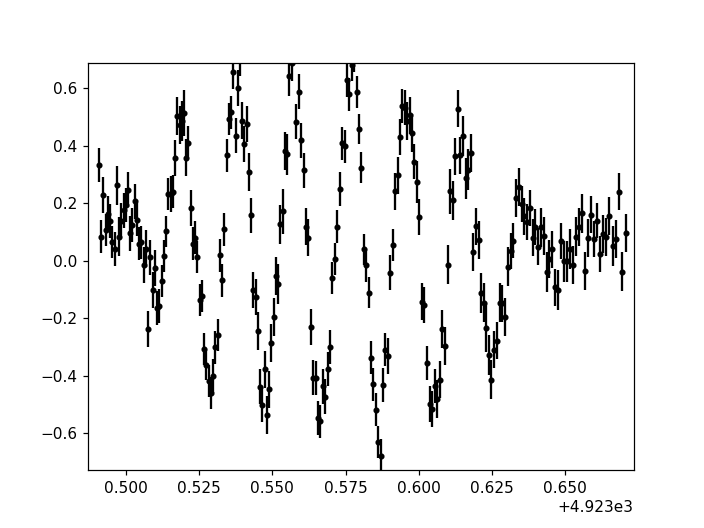

In [31]:
rv_data = np.loadtxt(par_dir + "/data/rv_betapic_carine.txt",usecols=(0,1,2))
rv_time = rv_data[:,0]
rv_flux = rv_data[:,1]
rv_error = rv_data[:,2]
plt.figure()
plt.errorbar(rv_time,rv_flux,yerr=rv_error,fmt='ok',markersize=3,capsize=0)
plt.show()

In [8]:
residus_plot = pd.read_csv(par_dir + "/data/residus_norm_rv.csv").ffill().set_index(['Photometry','Sector'])
residus_binned_0_1j_plot = pd.read_csv(par_dir + "/data/residus_norm_rv_binned_0.1j.csv").ffill().set_index(['Photometry','Sector'])
periodo_data_plot = pd.read_csv(par_dir + "/data/periodo_norm_rv_data.csv").ffill().set_index(['Photometry','Sector'])
periodo_data_binned_1j_plot = pd.read_csv(par_dir + "/data/periodo_norm_rv_data_binned_0.1j.csv").ffill().set_index(['Photometry','Sector'])
periodo_residus_plot = pd.read_csv(par_dir + "/data/periodo_norm_rv_residus.csv").ffill().set_index(['Photometry','Sector'])
periodo_residus_binned_1j_plot = pd.read_csv(par_dir + "/data/periodo_norm_rv_residus_binned_0.1j.csv").ffill().set_index(['Photometry','Sector'])

In [26]:
res = residus_plot.loc[(photometry,sector),"Value"].values
time = residus_plot.loc[(photometry,sector),"Time"].values


array([-0.01222936,  0.06746149, -0.00055102, ...,  0.14058546,
       -0.12386608,  0.02656524])

<IPython.core.display.Javascript object>


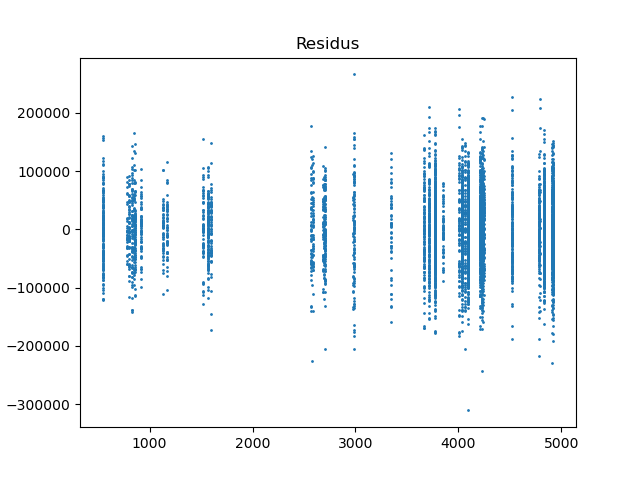

<IPython.core.display.Javascript object>


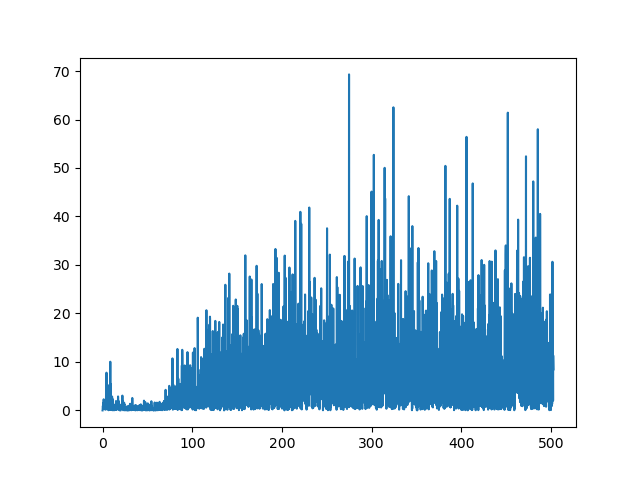

In [28]:
photometry = "TESS_ALL"
sector = "All"
time = residus_plot.loc[(photometry,sector),"Time"].values
res = residus_plot.loc[(photometry,sector),"Value"].values*1000
plt.figure()
plt.scatter(time,res*1000,s=1)
plt.title("Residus")
plt.show()


# time = residus_binned_0_1j_plot.loc[(photometry,sector),"Time"].values
# res = residus_binned_0_1j_plot.loc[(photometry,sector),"Value"].values

# fig, (ax, ax2) = plt.subplots(2, 1, sharey=True)
# index = np.argwhere(np.abs(res)>2*np.abs(np.std(res)))
# # plot the same data on both axes
# ax.scatter(time,res,s=1)
# ax.scatter(time[index],res[index],s=1,c='r')
# ax2.scatter(time,res,s=1)
# ax2.scatter(time[index],res[index],s=1,c='r')
# # zoom-in / limit the view to different portions of the data
# ax.set_xlim(1437,1525)  # outliers only
# ax2.set_xlim(2150,2275)
# plt.title("Residus binned 0.1j")
# plt.show()

# print(np.std(res))







# # hdul = fits.open(par_dir + '/data/TESS_18_2_data.fits')
# # data = hdul[1].data
# # time = data['TIME']
# # flux = data['PDCSAP_FLUX']
# # flux_error = data['PDCSAP_FLUX_ERR']
# # index = np.argwhere((~np.isnan(flux)) & (data["QUALITY"] == 0))
# # time = np.ndarray.flatten(time[index])
# # flux = np.ndarray.flatten(flux[index])
# # flux_error = np.ndarray.flatten(flux_error[index])

# # bins = np.arange(np.min(time),np.max(time)+0.1,0.1)
# # bin_mean,edges,number = stats.binned_statistic(time,flux,statistic='mean',bins=bins)
# # bin_width = (edges[1] - edges[0])
# # bin_centers = edges[1:] - bin_width/2

# # plt.figure()
# # plt.plot(bin_centers,bin_mean)
# # plt.show()

# # bins_res = np.arange(np.min(f_residus),np.max(f_residus)+1,1)
# # bin_mean_res,edges_res,number = stats.binned_statistic(f_residus,P_residus,statistic='mean',bins=bins_res)
# # bin_width_res = (edges_res[1] - edges_res[0])
# # bin_centers_res = edges_res[1:] - bin_width_res/2  
(time[1]-time[0])
frequency, psd = signal.periodogram(res,fs)
# frequency = periodo_residus_plot.loc[(photometry,sector),"Frequency"].values
# psd = periodo_residus_plot.loc[(photometry,sector),"PSD"].values
plt.figure()
plt.plot(frequency,psd)
plt.show()